In [1]:
# TODO
# Make function to plot aggregated evolving contours and store files
# Modify find contours function or use if statement to achieve less than 10% of contours intersecting with buffer
# Import/read ATL11 (try h5coro)
# Add ATL11 overlay
# Add something along the lines of code below to illustrate lake area/outline:
# # Plot polygons in the GeoDataFrame
# gdf.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=1, label='Polygon Area')

# # Optionally, if you want to plot just the boundaries with a different style
# gdf.boundary.plot(ax=ax, color='red', linewidth=2, label='Polygon Boundary')

# In find_outlines_and_plot add steps to:
# add off-lake dh/dt column; perhaps use unary_union of evolving outlines polys in each timestep

# lake_name='KT1'    
# outline = SiegfriedFricker2018_outlines[(SiegfriedFricker2018_outlines['name'] == lake_name)]
# region = outline['geometry'].buffer(10000)

# # Clip ATL15 to lake outline and region
# ATL15_dh_sub.rio.write_crs("epsg:3031", inplace=True)
# ATL15_outline = ATL15_dh_sub.rio.clip(outline.geometry.values, outline.crs)
# ATL15_region = ATL15_dh_sub.rio.clip(region.geometry.values, region.crs)
# ATL15_region = ATL15_dh_sub.rio.clip(outline.geometry.values, outline.crs, invert=True)

# Simplify subsetting code:
# CS2_dh_sub = CS2_dh.sel(y=slice(y_max, y_min), x=slice(x_min, x_max))
# ATL15_dh_sub = ATL15_dh.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))

In [2]:
# Code to Fig. S1 of Sauthoff and others, 2024
# This code run continental-scale operations on multiple datasets and
# requires a 64 GB server or local memory
#
# Written 2023-07-11 by W. Sauthoff (wsauthoff.github.io)

# Set up computing environment

In [3]:
%pip install openpyxl

  Using cached openpyxl-3.1.2-py2.py3-none-any.whl (249 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)
Note: you may need to restart the kernel to use updated packages.


In [114]:
# Import libraries
import datetime
import earthaccess
import gc
import geopandas as gpd
from IPython.display import clear_output
import matplotlib
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
import matplotlib.colors as colors
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerTuple
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import os
from os import path
from pyproj import CRS, Transformer
import rioxarray
from rioxarray.exceptions import NoDataInBounds
from shapely.geometry import box, Polygon
from shapely.ops import unary_union
from skimage import measure
import xarray as xr

# Magic functions
%matplotlib widget
# %matplotlib inline

from IPython.display import Audio, display
def play_sound():
    display(Audio(url="http://codeskulptor-demos.commondatastorage.googleapis.com/pang/pop.mp3", autoplay=True))

# Define data directories dependent on home environment
# Replace with your directory file paths
if os.getenv('HOME') == '/home/jovyan':
    DATA_DIR = '/home/jovyan/data'
    SCRIPT_DIR = '/home/jovyan/repos_my/script_dir'
    OUTPUT_DIR = '/home/jovyan/1_outlines_candidates/output/FigS1_lake_reexamination_methods.ipynb'

# Define constants and coordinate transforms for the geodesic area calculation
CRS_LL = "EPSG:4326" # wgs84 in lon,lat
GEOD = CRS(CRS_LL).get_geod() # geod object for calculating geodesic area on defined ellipsoid
CRS_XY = "EPSG:3031" # Antarctic Polar Stereographic in x, y
XY_TO_LL = Transformer.from_crs(CRS_XY, CRS_LL, always_xy = True) # make coord transformer

# Change default font to increase font size
plt.rcParams.update({'font.size': 8})

# Functions

In [123]:
# def read_field(group, field):
#     """
#     generic field-reading function
#     """
#     data=np.array(group[field])
#     bad=(data==group[field].attrs['_FillValue'])
#     data[bad]=np.NaN
#     return data

In [137]:
# def read_ATL11(filename, pair):
#     """
#     ATL11 reader
#     """
#     with h5py.File(filename,'r') as h5f:
#         longitude=read_field(h5f[pair],'longitude')
#         latitude=read_field(h5f[pair],'latitude')
#         h_corr=read_field(h5f[pair],'h_corr')
#         h_corr_sigma=read_field(h5f[pair],'h_corr_sigma')
#         h_corr_sigma_s=read_field(h5f[pair],'h_corr_sigma_systematic')
#         quality=np.array(h5f[pair]['quality_summary'])
#     for col in range(h_corr.shape[1]):
#         h_corr[quality==1]=np.NaN
#     # return the values
#     return longitude, latitude, h_corr, np.sqrt(h_corr_sigma**2+h_corr_sigma_s**2)

In [138]:
def datetime64_to_fractional_year(date):
    """
    Convert a numpy.datetime64 object into a fractional year, rounded to 0, .25, .5, or .75.
    """
    year = date.astype('datetime64[Y]').astype(int) + 1970
    start_of_year = np.datetime64(f'{year}-01-01')
    start_of_next_year = np.datetime64(f'{year + 1}-01-01')
    year_length = (start_of_next_year - start_of_year).astype('timedelta64[D]').astype(int)
    day_of_year = (date - start_of_year).astype('timedelta64[D]').astype(int)
    fractional_year = year + day_of_year / year_length

    # Round to nearest quarter
    rounded_fractional_year = round(fractional_year * 4) / 4
    return rounded_fractional_year

# # Example usage
# date = np.datetime64('2024-01-05')
# fractional_year = datetime64_to_fractional_year(date)

In [139]:
def muliple_area_buffer(polygon, area_multiple, precision=100):
    """
    This function takes a polygon and returns a polygon with a buffer such that the area of the buffered polygon
    is approximately the specified multiple the area of the original polygon.

    :param polygon: Shapely Polygon object
    :param area_multiple: the multiple of the original polygon area you wish the buffered polygon to be
    :param precision: Precision for the iterative process to find the buffer distance
    :return: Buffered Polygon
    """
    original_area = polygon.area
    target_area = area_multiple * original_area
    buffer_distance = 0
    buffered_polygon = polygon

    while True:
        buffered_polygon = polygon.buffer(buffer_distance)
        if buffered_polygon.area >= target_area:
            break
        buffer_distance += precision
    
    # Convert to geodataframe
    buffered_polygon_gdf = gpd.GeoDataFrame({'geometry': [buffered_polygon]})
    
    # Set CRS
    buffered_polygon_gdf.geometry.crs = 'EPSG:3031'

    return buffered_polygon_gdf

# # Example usage
# # Define a simple square polygon
# square = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])

# # Apply the function to find the buffered polygon area and bounds
# buffered_poly = double_area_buffer(square)
# buffered_poly.area, buffered_poly.bounds

In [140]:
def create_folder(directory):
    # Check if the directory already exists
    if not os.path.exists(directory):
        # If it doesn't exist, create a new directory
        os.makedirs(directory)
        print(f"Folder '{directory}' created successfully.")
    else:
        print(f"Folder '{directory}' already exists.")

In [141]:
def plot_data_counts(lake_gdf, dataset1, dataset2): 
    '''
    Create planview plots of counts going into gridded ice-surface height change (dh/dt) products
    
    Inputs:
    * lake_gdf: geodataframe of lake to be analyzed
    * dataset1: dataset1 to be analyzed
    * dataset2: dataset2 to be analyzed in conjunction with dataset1; currently configured to 
    splice CryoSat-2 and ICESat-2 eras
    
    Outputs:
    * Sequence of planview data count visuals of lake around surrounding area
    '''
    # Define lake name and polygon
    lake_name = lake_gdf.name.values[0]
    lake_poly = lake_gdf.iloc[0].geometry
    
    # # Create buffered polygons for various multiples of lake area to find which
    # # best emcompasses the height change signals at previously identified lakes
    buffered_poly_2x = muliple_area_buffer(lake_poly, 2)
    # buffered_poly_3x = muliple_area_buffer(lake_poly, 3)
    # buffered_poly_4x = muliple_area_buffer(lake_poly, 4)
    # buffered_poly_5x = muliple_area_buffer(lake_poly, 5)
    
    # Establish x_min, x_max, y_min, y_max
    x_min, y_min, x_max, y_max = buffered_poly_2x.iloc[0].geometry.bounds
    x_buffer = abs(x_max-x_min)*0.5
    y_buffer = abs(y_max-y_min)*0.5

    # Subsetting datasets
    mask_x = (dataset1.x >= x_min - x_buffer) & (dataset1.x <= x_max + x_buffer)
    mask_y = (dataset1.y >= y_min - y_buffer) & (dataset1.y <= y_max + y_buffer)
    dataset1_subset = dataset1.where(mask_x & mask_y, drop=True)
    mask_x = (dataset2.x >= x_min - x_buffer) & (dataset2.x <= x_max + x_buffer)
    mask_y = (dataset2.y >= y_min - y_buffer) & (dataset2.y <= y_max + y_buffer)
    dataset2_subset = dataset2.where(mask_x & mask_y, drop=True)
    
    # Make output folders
    create_folder(OUTPUT_DIR + '/{}'.format('plot_data_counts'))
    create_folder(OUTPUT_DIR + '/plot_data_counts/{}'.format(lake_name))
    print('Now creating/saving plots...')

    # Create lines for legend
    S09_color = 'cyan'
    SF18_color  = 'darkcyan'
    lakes_notSF18_color = 'deepskyblue'
    Smith2009 = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 3)), linewidth=2)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=(0, (1, 2)), linewidth=2)
    lakes_notSF18 = plt.Line2D((0, 1), (0, 0), color=lakes_notSF18_color, linestyle=(0, (1, 1)), linewidth=2)

    # Calculate cycle-to-cycle dHeight at each cycle of the spliced data sets
    for idx in range(len(midcyc_dates)):
        # For midcyc_dates indexes <= 32, use CryoSat-2 dataset for cycle-to-cycle dHeight
        # This covers the CryoSat-2 era before ICESat-2 launch (2010-08-17 to 2018-08-17)
        if idx <= 32:
            count_subset = dataset1_subset['data_count'][idx,:,:]
            count_subset.rio.write_crs("epsg:3031", inplace=True)

        # For midcyc_dates indexes > 32, use ICESat-2 dataset for cycle-to-cycle dHeight
        # This covers the ICESat-2 era (2018-11-16 to most recently available data)
        elif idx > 32:
            # Subtract 33 from idx to start over at index zero with new dataset
            count_subset = dataset2_subset['data_count'][(idx-33),:,:]
            count_subset.rio.write_crs("epsg:3031", inplace=True)
            
        # Only plot arrays that have data in them; some time slices have no data because no CryoSat-2 SARIn coverage
        # Returns True if there is at least one non-NaN value in data_stacked, and False if all values are NaN
        if np.any(~np.isnan(count_subset)):
            # Create fig, ax
            fig, ax = plt.subplots()

            # Plot figure
            img = ax.imshow(count_subset, extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer], 
                origin='lower', cmap='viridis')

            # Plot buffered polygons
            buffered_poly_2x.boundary.plot(ax=ax, edgecolor='k', facecolor='none', linewidth=0.5)
            # buffered_poly_3x.boundary.plot(ax=ax, edgecolor='k', facecolor='none', linewidth=0.5)
            # buffered_poly_4x.boundary.plot(ax=ax, edgecolor='k', facecolor='none', linewidth=0.5)
            # buffered_poly_5x.boundary.plot(ax=ax, edgecolor='k', facecolor='none', linewidth=0.5)
            
            # Overlay published active lake outlines for visual comparison and grounding line
            # S09_outlines.boundary.plot(ax=ax, facecolor=S09_color, linestyle=(0, (1, 10)), linewidth=2, alpha=0.25)
            SF18_outlines_S09only.boundary.plot(ax=ax, edgecolor=S09_color, linestyle=(0, (1, 3)), linewidth=2)
            # SF18_outlines_SF18only.boundary.plot(ax=ax, facecolor=SF18_color, linestyle=(0, (1, 3)), linewidth=2, alpha=0.25)
            SF18_outlines_SF18only.boundary.plot(ax=ax, edgecolor=SF18_color, linestyle=(0, (1, 2)), linewidth=2)
            # Sauthoff2023_S23outlines.boundary.plot(ax=ax, facecolor=S23_color, linestyle=(0, (1, 1)), linewidth=2, alpha=0.25)
            lake_locations_notSF18.boundary.plot(ax=ax, edgecolor=lakes_notSF18_color, linestyle=(0, (1, 1)), linewidth=2)          
            
            # Change polar stereographic m to km
            km_scale = 1e3
            ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
            ax.xaxis.set_major_formatter(ticks_x)
            ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
            ax.yaxis.set_major_formatter(ticks_y)  

            # Label axes, set limits, and set title
            ax.set_xlabel('x [km]', size=15)
            ax.set_ylabel('y [km]', size=15) 
            ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

#             # Plot inset map
#             axIns = ax.inset_axes([0.01, 0.01, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
#             axIns.set_aspect('equal')
#             moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
#             moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
#             axIns.axis('off')

#             # Plot red star to indicate location
#             axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
#                 linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)

            # Add colorbar 
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.2)
            fig.colorbar(img, cax=cax).set_label('data counts', size=15)

            # Add legend
            ax.legend([Smith2009, 
                       SiegfriedFricker2018, 
                       lakes_notSF18
                      ],
                ['static outline (S09)', 
                 'static outline (SF18)', 
                 'other'
                ], 
                loc='upper center')
            
            # Set a title for the axes
            ax.set_title('Data counts from from {} to {}'.format(cyc_start_dates[idx].astype('datetime64[D]').astype(str), cyc_end_dates[idx].astype('datetime64[D]').astype(str)))
            
            # Save and close fig
            plt.savefig(OUTPUT_DIR + 
                '/plot_data_counts/{}/plot_data_counts_{}_{}-{}.png'
                .format(lake_name, lake_name, cyc_start_dates[idx].astype('datetime64[D]').astype(str), cyc_end_dates[idx].astype('datetime64[D]').astype(str)), dpi=300, bbox_inches='tight')
            plt.close()
    print('Complete')
        
# # Example usage
# plot_data_counts(lake_gdf=lake_gdf, dataset1=CS2_Smith2017, dataset2=ATL15_dh): 

In [142]:
def plot_height_changes(lake_gdf, dataset1, dataset2): 
    '''
    Create planview plots of ice surface height changes (dh/dt)
    
    Inputs:
    * lake_gdf: geodataframe of lake to be analyzed
    * dataset1: dataset1 to be analyzed
    * dataset2: dataset2 to be analyzed in conjunction with dataset1; currently configured to 
    splice CryoSat-2 and ICESat-2 eras
    
    Outputs: 
    * Sequence of planview delta height visuals of lake around surrounding area
    '''
    # Define lake name and polygon
    lake_name = lake_gdf.name.values[0]
    lake_poly = lake_gdf.iloc[0].geometry
    
    # Create buffered polygons for various multiples of lake area to find which
    # best emcompasses the height change signals at previously identified lakes
    buffered_poly_2x = muliple_area_buffer(lake_poly, 2)
    # buffered_poly_3x = muliple_area_buffer(lake_poly, 3)
    # buffered_poly_4x = muliple_area_buffer(lake_poly, 4)
    # buffered_poly_5x = muliple_area_buffer(lake_poly, 5)

    # Establish x_min, x_max, y_min, y_max
    x_min, y_min, x_max, y_max = buffered_poly_2x.iloc[0].geometry.bounds
    x_buffer = abs(x_max-x_min)*0.5
    y_buffer = abs(y_max-y_min)*0.5
    
    # Subsetting datasets
    mask_x = (dataset1.x >= x_min - x_buffer) & (dataset1.x <= x_max + x_buffer)
    mask_y = (dataset1.y >= y_min - y_buffer) & (dataset1.y <= y_max + y_buffer)
    dataset1_subset = dataset1.where(mask_x & mask_y, drop=True)
    mask_x = (dataset2.x >= x_min - x_buffer) & (dataset2.x <= x_max + x_buffer)
    mask_y = (dataset2.y >= y_min - y_buffer) & (dataset2.y <= y_max + y_buffer)
    dataset2_subset = dataset2.where(mask_x & mask_y, drop=True)
    
    # Find magnitude of ice surface deformation in bounding box to create appropriate color map scale
    # Create empty lists to store data
    height_anom_pos = []
    height_anom_neg = []
    for idx in range(len(midcyc_dates)):
        if idx <= 32:
            dhdt_subset = dataset1_subset.delta_h[idx+1,:,:]-dataset1_subset.delta_h[idx,:,:]
        elif idx > 32:
            # Subtract 33 from idx to start over at index zero with new dataset
            dhdt_subset = dataset2_subset.delta_h[(idx-33)+1,:,:]-dataset2_subset.delta_h[(idx-33),:,:]
        if np.any(~np.isnan(dhdt_subset)):       
            pos = np.nanmax(dhdt_subset)
            neg = np.nanmin(dhdt_subset)
            height_anom_pos += [pos]
            height_anom_neg += [neg]
    
    # Store max pos/neg height anomalies from all cycles to create colorbar bounds later
    max_height_anom_pos = max(height_anom_pos)
    max_height_anom_neg = min(height_anom_neg)
    
    # Establish diverging colorbar
    divnorm=colors.TwoSlopeNorm(vmin=max_height_anom_neg, vcenter=0., vmax=max_height_anom_pos)
   
    # Make output folders
    create_folder(OUTPUT_DIR + '/{}'.format('plot_height_changes'))
    create_folder(OUTPUT_DIR + '/plot_height_changes/{}'.format(lake_name))
    print('Now creating/saving plots...')

    # Create lines for legend
    S09_color = 'cyan'
    SF18_color  = 'darkcyan'
    lakes_notSF18_color = 'deepskyblue'
    Smith2009 = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 3)), linewidth=2)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=(0, (1, 2)), linewidth=2)
    lakes_notSF18 = plt.Line2D((0, 1), (0, 0), color=lakes_notSF18_color, linestyle=(0, (1, 1)), linewidth=2)

    # Calculate cycle-to-cycle dHeight at each cycle of the spliced data sets
    for idx in range(len(midcyc_dates)):
        # For midcyc_dates indexes <= 32, use CryoSat-2 dataset for cycle-to-cycle dHeight
        # This covers the CryoSat-2 era before ICESat-2 launch (2010-08-17 to 2018-08-17)
        if idx <= 32:
            dhdt_subset = dataset1_subset.delta_h[idx+1,:,:]-dataset1_subset.delta_h[idx,:,:]
            # dhdt_subset.rio.write_crs("epsg:3031", inplace=True)

        # For midcyc_dates indexes > 32, use ICESat-2 dataset for cycle-to-cycle dHeight
        # This covers the ICESat-2 era (2018-11-16 to most recently available data)
        elif idx > 32:
            # Subtract 33 from idx to reset idx to zero for new dataset
            dhdt_subset = dataset2_subset.delta_h[(idx-33)+1,:,:]-dataset2_subset.delta_h[(idx-33),:,:]
            # dhdt_subset.rio.write_crs("epsg:3031", inplace=True)

        # Only plot arrays that have data in them; some time slices have no data because no CryoSat-2 SARIn coverage
        # Returns True if there is at least one non-NaN value in data_stacked, and False if all values are NaN
        if np.any(~np.isnan(dhdt_subset)):
            # Create fig, ax
            fig, ax = plt.subplots()

            # Plot figure
            img = ax.imshow(dhdt_subset, extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer],
                origin='lower', cmap='coolwarm_r', 
                # norm=colors.CenteredNorm())
                norm=divnorm)

            # Plot buffered polygons
            buffered_poly_2x.boundary.plot(ax=ax, edgecolor='k', facecolor='none', linewidth=0.5)
            # buffered_poly_3x.boundary.plot(ax=ax, edgecolor='k', facecolor='none', linewidth=0.5)
            # buffered_poly_4x.boundary.plot(ax=ax, edgecolor='k', facecolor='none', linewidth=0.5)
            # buffered_poly_5x.boundary.plot(ax=ax, edgecolor='k', facecolor='none', linewidth=0.5)
            
            # Overlay published active lake outlines for visual comparison and grounding line
            # S09_outlines.boundary.plot(ax=ax, facecolor=S09_color, linestyle=(0, (1, 10)), linewidth=2, alpha=0.25)
            SF18_outlines_S09only.boundary.plot(ax=ax, edgecolor=S09_color, linestyle=(0, (1, 3)), linewidth=2)
            # SF18_outlines_SF18only.boundary.plot(ax=ax, facecolor=SF18_color, linestyle=(0, (1, 3)), linewidth=2, alpha=0.25)
            SF18_outlines_SF18only.boundary.plot(ax=ax, edgecolor=SF18_color, linestyle=(0, (1, 2)), linewidth=2)
            # Sauthoff2023_S23outlines.boundary.plot(ax=ax, facecolor=S23_color, linestyle=(0, (1, 1)), linewidth=2, alpha=0.25)
            lake_locations_notSF18.boundary.plot(ax=ax, edgecolor=lakes_notSF18_color, linestyle=(0, (1, 1)), linewidth=2)          
            
            # Change polar stereographic m to km
            km_scale = 1e3
            ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
            ax.xaxis.set_major_formatter(ticks_x)
            ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
            ax.yaxis.set_major_formatter(ticks_y)  

            # Label axes, set limits, and set title
            ax.set_xlabel('x [km]', size=15)
            ax.set_ylabel('y [km]', size=15) 
            ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

#             # Plot inset map
#             axIns = ax.inset_axes([0.01, 0.01, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
#             axIns.set_aspect('equal')
#             moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
#             moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
#             axIns.axis('off')

#             # Plot red star to indicate location
#             axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
#                 linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)

            # Add colorbar 
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.2)
            fig.colorbar(img, cax=cax).set_label('height change (dh) [m]', size=15)

            # Add legend
            ax.legend([Smith2009, 
                       SiegfriedFricker2018, 
                       lakes_notSF18
                      ],
                ['static outline (S09)', 
                 'static outline (SF18)', 
                 'other'
                ], 
                loc='upper center')
            
            # Set a title for the axes
            ax.set_title('Height change from from {} to {}'.format(cyc_start_dates[idx].astype('datetime64[D]').astype(str), cyc_end_dates[idx].astype('datetime64[D]').astype(str)))
            
            # Save and close fig
            plt.savefig(OUTPUT_DIR + 
                '/plot_height_changes/{}/plot_height_changes+{}_{}-{}.png'
                .format(lake_name, lake_name, cyc_start_dates[idx].astype('datetime64[D]').astype(str), cyc_end_dates[idx].astype('datetime64[D]').astype(str)), dpi=300, bbox_inches='tight')
            plt.close()
    print('Complete')
        
# # Example usage
# plot_height_changes(lake_gdf=lake_gdf, dataset1=CS2_Smith2017, dataset2=ATL15_dh): 

In [154]:
def find_evolving_outlines(lake_gdf, area_multiple_search_extent, level, dataset1, dataset2, plot=False): 
    '''
    Create planview dh/dt plots of ice surface height changes 
    Create time-variable outlines using skimage contour to plot evolving outlines as polygons.
    
    Inputs:
    * ROI_name: str of the region of interest for using in file name saving
    * ROI_poly: list of polygon(s) that define evolving outline search extent
    * level: vertical distance in meters to delineate ice surface deformation contour
    * dataset1: dataset1 to be analyzed
    * dataset2: dataset2 to be analyzed in conjunction with dataset1; currently configured to 
    splice CryoSat-2 and ICESat-2 eras
    
    Outputs: 
    * Sequence of planview delta height visuals of ICESat-2 ATL15 with variable ice surface 
    deformation contours plotted to delineate evolving lake boundaries.
    * geopandas geodataframe of polygons created at each step (would need to modify to collect all polygons 
    at all time steps)
    '''
    # Define lake name and polygon
    lake_name = lake_gdf.name.values[0]
    lake_poly = lake_gdf.iloc[0].geometry
    buffered_gdf = muliple_area_buffer(lake_poly, area_multiple_search_extent+1)
    
    # Clipping datasets
    if dataset1 != 'none':
        dataset1_clipped = dataset1.rio.clip(buffered_gdf.geometry, dataset1.rio.crs)
    dataset2_clipped = dataset2.rio.clip(buffered_gdf.geometry, dataset2.rio.crs)
    
    # Establish x_min, x_max, y_min, y_max
    x_min, y_min, x_max, y_max = buffered_gdf.iloc[0].geometry.bounds
    x_buffer = abs(x_max-x_min)*0.2
    y_buffer = abs(y_max-y_min)*0.2
   
    # Only proceed with plotting if plot=True
    if plot:
        # Create lines for legend
        S09_color = 'cyan'
        SF18_color  = 'darkcyan'
        lakes_notSF18_color = 'deepskyblue'
        Smith2009 = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 3)), linewidth=2)
        SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=(0, (1, 2)), linewidth=2)
        lakes_notSF18 = plt.Line2D((0, 1), (0, 0), color=lakes_notSF18_color, linestyle=(0, (1, 1)), linewidth=2)
        uplift = plt.Line2D((0, 1), (0, 0), color='mediumblue', linestyle='dashdot', linewidth=2)
        subsidence = plt.Line2D((0, 1), (0, 0), color='maroon', linestyle='dashdotdotted', linewidth=2)
    
    # Create empty list to store polygons, areas, dh's, dvol's and dates
    polys = []
    areas = []
    dhs = []
    dvols =[]
    midcyc_datetimes = []

    # Calculate cycle-to-cycle dHeight at each cycle of the spliced data sets
    for idx in range(len(midcyc_dates)-1):  # Less one because cycle-to-cycle differencing reduces length by one
        # For midcyc_dates indexes <= 32, use CryoSat-2 dataset for cycle-to-cycle dHeight
        # This covers the CryoSat-2 era before ICESat-2 launch (2010-08-17 to 2018-08-17)
        if idx <= 32:
            if dataset1 != 'none':
                dhdt_clipped = dataset1_clipped.delta_h[idx+1,:,:]-dataset1_clipped.delta_h[idx,:,:]
                dhdt_clipped.rio.write_crs("epsg:3031", inplace=True)
            else:
                continue
        # For midcyc_dates indexes > 32, use ICESat-2 dataset for cycle-to-cycle dHeight
        # This covers the ICESat-2 era (2018-11-16 to most recently available data)
        elif idx > 32:
            # Subtract 33 from idx to start over at index zero with new dataset
            dhdt_clipped = dataset2_clipped.delta_h[(idx-33)+1,:,:]-dataset2_clipped.delta_h[(idx-33),:,:]
            dhdt_clipped.rio.write_crs("epsg:3031", inplace=True)

        # Create mapping conversion factor to map array location to polar stereographic x,y
        x_conv = (x_max-x_min)/dhdt_clipped.shape[1]
        y_conv = (y_max-y_min)/dhdt_clipped.shape[0]

        # Only plot arrays that have data in them; some time slices have no data because no CryoSat-2 SARIn coverage
        # Returns True if there is at least one non-NaN value in data_stacked, and False if all values are NaN
        if np.any(~np.isnan(dhdt_clipped)):
            if plot:
                # Create fig, ax
                fig, ax = plt.subplots()

                # Plot figure
                img = ax.imshow(dhdt_clipped, extent=[x_min, x_max, y_min, y_max], 
                    origin='lower', cmap='coolwarm_r', 
                    norm=colors.CenteredNorm())

                # Plot the boundary of the evolving outline search extent
                gpd.GeoSeries(buffered_gdf.iloc[0].geometry).boundary.plot(ax=ax, color='red')

            # Create empty lists to store contours 
            contours_pos = []
            contours_neg = []

            # Create contours at the positive and negative threshold 
            contour_pos = measure.find_contours(dhdt_clipped.values, level)
            # If at least one contour, add to list of contours
            if len(contour_pos) > 0: 
                contours_pos += [contour_pos]
            contour_neg = measure.find_contours(dhdt_clipped.values, -level)
            if len(contour_neg) > 0: 
                contours_neg += [contour_neg]

            # Plot contours and make into polygons
            for i in range(len(contours_pos)): 
                for j in range(len(contours_pos[i])):
                    x = x_min+contours_pos[i][j][:,1]*x_conv
                    y = y_min+contours_pos[i][j][:,0]*y_conv
                    if plot:
                        ax.plot(x, y, color='mediumblue', linestyle='dashdot', linewidth=1, label=level)

                    # Make polygons from evolving outlines and store to list
                    if len(contours_pos[i][j][:,1]) > 2: 
                        poly = Polygon(list(zip(x, y)))
                        try:
                            dhdt_poly = dhdt_clipped.rio.clip([poly])
                            lon, lat = XY_TO_LL.transform(x,y)
                            poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])
                            if np.any(~np.isnan(dhdt_poly)):
                                poly_dh = np.nanmean(dhdt_poly)
                                poly_dvol = poly_dh*poly_area
                                polys += [poly]
                                areas += [poly_area]
                                dhs += [poly_dh]
                                dvols += [poly_dvol]
                                midcyc_datetimes += [midcyc_dates[idx]]
                        except NoDataInBounds:
                            continue  # Skip to the next iteration
                        except Exception as e:
                            # Handle any other exceptions
                            raise

            for i in range(len(contours_neg)): 
                for j in range(len(contours_neg[i])):
                    x = x_min+contours_neg[i][j][:,1]*x_conv
                    y = y_min+contours_neg[i][j][:,0]*y_conv
                    if plot:
                        ax.plot(x, y, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=1, label=-level)

                    if len(contours_neg[i][j][:,1]) > 2: 
                        poly = Polygon(list(zip(x, y)))
                        try:
                            dhdt_poly = dhdt_clipped.rio.clip([poly])
                            lon, lat = XY_TO_LL.transform(x,y)
                            poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])
                            if np.any(~np.isnan(dhdt_poly)):
                                poly_dh = np.nanmean(dhdt_poly)
                                poly_dvol = poly_dh*poly_area
                                polys += [poly]
                                areas += [poly_area]
                                dhs += [poly_dh]
                                dvols += [poly_dvol]
                                midcyc_datetimes += [midcyc_dates[idx]]
                        except NoDataInBounds:
                            continue  # Skip to the next iteration
                        except Exception as e:
                            # Handle any other exceptions
                            raise

            if plot:
                # Overlay published active lake outlines for visual comparison and grounding line
                S09_color = 'cyan'
                SF18_color  = 'darkcyan'
                lake_locations_notSF18_color = 'deepskyblue'
                # S09_outlines.boundary.plot(ax=ax, facecolor=S09_color, linestyle=(0, (1, 10)), linewidth=2, alpha=0.25)
                S09_outlines.boundary.plot(ax=ax, edgecolor=S09_color, linestyle=(0, (1, 10)), linewidth=2)
                # SF18_outlines_SF18only.boundary.plot(ax=ax, facecolor=SF18_color, linestyle=(0, (1, 3)), linewidth=2, alpha=0.25)
                SF18_outlines_SF18only.boundary.plot(ax=ax, edgecolor=SF18_color, linestyle=(0, (1, 3)), linewidth=2)
                # Sauthoff2023_S23outlines.boundary.plot(ax=ax, facecolor=S23_color, linestyle=(0, (1, 1)), linewidth=2, alpha=0.25)
                lake_locations_notSF18.boundary.plot(ax=ax, edgecolor=lake_locations_notSF18_color, linestyle=(0, (1, 1)), linewidth=2)

                # Change polar stereographic m to km
                km_scale = 1e3
                ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
                ax.xaxis.set_major_formatter(ticks_x)
                ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
                ax.yaxis.set_major_formatter(ticks_y)  

                # Label axes, set limits, and set title
                ax.set_xlabel('x [km]', size=15)
                ax.set_ylabel('y [km]', size=15) 
                ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

                # Plot inset map
                axIns = ax.inset_axes([-0.01, 0.01, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
                axIns.set_aspect('equal')
                moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
                moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
                axIns.axis('off')

                # # Plot black rectangle to indicate location
                # rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
                # axIns.add_artist(rect)

                # Plot red star to indicate location
                axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
                    linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)

                # Add colorbar 
                divider = make_axes_locatable(ax)
                cax = divider.append_axes('right', size='5%', pad=0.2)
                fig.colorbar(img, cax=cax).set_label('height change (dh) [m]', size=15)

                # Add legend
                ax.legend([Smith2009, 
                           SiegfriedFricker2018, 
                           Sauthoff2024,
                           uplift, 
                           subsidence],
                    ['static outline (S09)', 
                     'static outline (SF18)', 
                     'other',
                     ('+ '+str(level)+' m uplift evolving outline'), 
                     ('– '+str(level)+' m subsidence evolving outline')], 
                    loc='upper left')

                # Set a title for the axes
                ax.set_title('Evolving outlines and height change \nfrom from {} to {}'.format(cyc_start_dates[idx].astype('datetime64[D]').astype(str), cyc_end_dates[idx].astype('datetime64[D]').astype(str)))

                # Save and close fig
                plt.savefig(OUTPUT_DIR + 
                    '/find_evolving_outlines/{}/find_evolving_outlines_{}_{}m-level_{}-{}.png'
                    .format(lake_name, lake_name, level, cyc_start_dates[idx].astype('datetime64[D]').astype(str), cyc_end_dates[idx].astype('datetime64[D]').astype(str)), dpi=300, bbox_inches='tight')
                plt.close()
    
    # Store polygons in geopandas geodataframe for further analysis
    area_multiple_search_extents = [area_multiple_search_extent for _ in range(len(polys))]
    levels = [level for _ in range(len(polys))]
    d = {'area_multiple_search_extent': area_multiple_search_extents,
         'level': levels,
         'geometry': polys, 
         'area (m^2)': areas, 
         'dh (m)': dhs, 
         'vol (m^3)': dvols,
         'midcyc_datetime': midcyc_datetimes}
    gdf = gpd.GeoDataFrame(d, crs="EPSG:3031")
    gdf['centroid'] = gdf['geometry'].centroid

    return gdf

# # Example usage
# outlines_gdf = find_evolving_outlines(lake_gdf=lake_gdf, area_multiple_search_extent=2, level=0.1, dataset1=dataset1, dataset2=dataset2, plot=False)

In [145]:
def plot_evolving_outlines(lake_gdf, outlines_gdf):
    '''
    Func to plot evolving outlines in aggregate
    '''
    # Create fig, ax
    fig, ax = plt.subplots(figsize=(5,5))
    
    # Define lake name and polygon
    lake_name = lake_gdf.name.values[0]
    lake_poly = lake_gdf.iloc[0].geometry
    
    # Create buffered polygons for various multiples of lake area to find which
    # best emcompasses the height change signals at previously identified lakes
    buffered_poly_2x = muliple_area_buffer(lake_poly, 2)
    buffered_poly_3x = muliple_area_buffer(lake_poly, 3)
    buffered_poly_4x = muliple_area_buffer(lake_poly, 4)
    buffered_poly_5x = muliple_area_buffer(lake_poly, 5)
    
    # Plot buffered polygons
    buffered_poly_2x.boundary.plot(ax=ax, edgecolor='k', facecolor='none', linewidth=0.5)
    buffered_poly_3x.boundary.plot(ax=ax, edgecolor='k', facecolor='none', linewidth=0.5)
    buffered_poly_4x.boundary.plot(ax=ax, edgecolor='k', facecolor='none', linewidth=0.5)
    buffered_poly_5x.boundary.plot(ax=ax, edgecolor='k', facecolor='none', linewidth=0.5)

    # Set colormap and normalize to date values
    cmap = plt.get_cmap('plasma', len(midcyc_dates)-1)
    norm = plt.Normalize(datetime64_to_fractional_year(midcyc_dates[0]), datetime64_to_fractional_year(midcyc_dates[-1]))
    m = plt.cm.ScalarMappable(cmap=cmap)
    m.set_array(np.array([datetime64_to_fractional_year(date) for date in midcyc_dates[0:-1]]))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="2.5%", pad=0.5)
    fig.colorbar(m, cax=cax, orientation='horizontal').set_label('evolving outline year', size=10)

    # Overlay published active lake outlines for visual comparison and grounding line
    S09_color = 'cyan'
    SF18_color  = 'darkcyan'
    S23_color = 'deepskyblue'
    S09_outlines.boundary.plot(ax=ax, facecolor=S09_color, linestyle=(0, (1, 3)), linewidth=2, alpha=0.25)
    S09_outlines.boundary.plot(ax=ax, edgecolor=S09_color, linestyle=(0, (1, 3)), linewidth=2)
    SF18_outlines_SF18only.boundary.plot(ax=ax, facecolor=SF18_color, linestyle=(0, (1, 2)), linewidth=2, alpha=0.25)
    SF18_outlines_SF18only.boundary.plot(ax=ax, edgecolor=SF18_color, linestyle=(0, (1, 2)), linewidth=2)
    Sauthoff2024_S24outlines.boundary.plot(ax=ax, facecolor=S23_color, linestyle=(0, (1, 1)), linewidth=2, alpha=0.25)
    Sauthoff2024_S24outlines.boundary.plot(ax=ax, edgecolor=S23_color, linestyle=(0, (1, 1)), linewidth=2)

    # Use for loop to plot each outline in the geopandas dataframe and color by date
    lines = []  # list of lines to be used for the legend
    for idx, dt in enumerate(midcyc_dates):
        x = 1; y = 1
        line, = ax.plot(x, y, color=cmap(norm(datetime64_to_fractional_year(midcyc_dates[idx]))), linewidth=5)
        lines.append(line)
        if any(outlines_gdf[outlines_gdf['midcyc_datetime'] == dt]):
            outlines_gdf[outlines_gdf['midcyc_datetime'] == dt].boundary.plot(ax=ax, 
                color=cmap(norm(datetime64_to_fractional_year(midcyc_dates[idx])))
                )

    # Change polar stereographic m to km for cleaner-looking axes labels
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.yaxis.set_major_formatter(ticks_y)
    ax.set_aspect('equal')

    # Label axes and set limits
    ax.set_xlabel('x [km]', size=10)
    ax.set_ylabel('y [km]', size=10)
    # Extract x_min, y_min, x_max, y_max from the total_bounds attribute
    x_min, y_min, x_max, y_max = outlines_gdf.total_bounds
    x_buffer = abs(x_max-x_min)*0.2
    y_buffer = abs(y_max-y_min)*0.2
    ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

    # Create lines for legend
    Smith2009 = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 3)), linewidth=5)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=(0, (1, 2)), linewidth=5)
    
    # Create legend
    ax.legend(handles=[Smith2009, 
        SiegfriedFricker2018, 
        tuple(lines)], 
        labels=['static outline (Smith and others, 2009)',
            'static outline (Siegfried & Fricker, 2018)', 
            # 'evolving outline ({} m threshold)'.format(threshold)], 
            'evolving outline (this study)'], 
              handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
             loc='upper left', bbox_to_anchor=(0, 1.2))

    # Plot inset map to show location 
    axIns = ax.inset_axes([0.02, 0.01, 0.25, 0.25]) # [left, bottom, width, height] (fractional axes coordinates)
    axIns.set_aspect('equal')
    moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
    moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
    axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', linewidth=1, edgecolor='k', facecolor='r', s=50, zorder=3)
    # rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
    # axIns.add_artist(rect) 
    axIns.axis('off')

    # plt.savefig(OUTPUT_DIR + '/plot_evolving_outlines_time_series/{}/plot_evolving_outlines_time_series_{}_{}km-buffer_{}m-threshold-{}outlines.png'
    #     .format(ROI, ROI, buffer/1e3, threshold, len(gdf)),
    #             dpi=300, bbox_inches='tight')

    plt.show()

In [146]:
def extract_intersecting_polygons(gdf, polygon):
    """
    Extract polygons from a GeoDataFrame that intersect with a specified polygon,
    as well as polygons that intersect with those intersected polygons.

    Parameters:
    gdf (geopandas.GeoDataFrame): A GeoDataFrame containing polygon geometries.
    polygon (shapely.Polygon): A shapely polygon

    Returns:
    geopandas.GeoDataFrame: A GeoDataFrame containing the polygons that either
                            intersect directly with the input polygon or intersect with
                            polygons that intersect with the initial polygon.
    """
    # Step 0: Deal with invalid geometries
    # Raise the input polygon if it's invalid
    if not polygon.is_valid:
        raise ValueError("Input polygon is invalid and will be excluded.")

    # Exclude invalid geometries in the GeoDataFrame before processing
    valid_gdf = gdf[gdf['geometry'].is_valid]
    
    # Step 1: Find polygons that intersect with the given polygon
    directly_intersecting = gdf[gdf.intersects(polygon)]

    # Ensure directly intersecting polygons are included in the final result set
    # This step might be redundant depending on the unary_union behavior but is included for clarity
    final_result = directly_intersecting.copy()

    # Step 2: Find polygons that intersect with the polygons found in Step 1
    # We use 'unary_union' to merge all polygons found in Step 1 into a single geometry
    # Then we select polygons from the original GeoDataFrame that intersect with this merged geometry
    indirectly_intersecting = gdf[gdf.intersects(directly_intersecting.unary_union)]

    # Step 3: Find polygons that intersect with the polygons found in Step 1
    # We use 'unary_union' to merge all polygons found in Step 1 into a single geometry
    # Then we select polygons from the original GeoDataFrame that intersect with this merged geometry
    second_indirectly_intersecting = gdf[gdf.intersects(indirectly_intersecting.unary_union)]

    # Combine both directly and indirectly intersecting polygons to ensure no duplicates
    result_polygons = gpd.GeoDataFrame(pd.concat([directly_intersecting, indirectly_intersecting, second_indirectly_intersecting], ignore_index=True).drop_duplicates(subset='geometry'))

    return result_polygons

In [147]:
# def remove_outlier_polygon(gdf, axis='x', max_or_min='max'):
#     '''
#     Func to remove outline outliers by removing a polygon
#     with the most extreme x or y coordinates
    
#     Inputs
#     * geopandas geodataframe
#     * axis indicates whether the x or y axis will 
#     have its extreme polygon removed
#     * max_or_min indicates whether the max or min centroid axis
#     value will be removed
    
#     Ouputs
#     * geopandas geodataframe with one outline removed
#     '''
    
#     # Check if the GeoDataFrame is empty
#     if gdf.empty:
#         print("GeoDataFrame is empty. Nothing to remove.")
#         return gdf
    
#     # Choose the axis and max or min for extreme value
#     if axis not in ['x', 'y']:
#         raise ValueError("Invalid axis. Use 'x' or 'y'.")
#     if max_or_min not in ['max', 'min']:
#         raise ValueError("Invalid max_or_min. Use 'max' or 'min'.")

#     # Calculate the centroid and extreme value
#     if axis == 'x':
#         if max_or_min == 'max':
#             idx_to_remove = gdf.geometry.bounds['maxx'].idxmax()
#         else:
#             idx_to_remove = gdf.geometry.bounds['minx'].idxmin()
#     else:
#         if max_or_min == 'max':
#             idx_to_remove = gdf.geometry.bounds['maxy'].idxmax()
#         else:
#             idx_to_remove = gdf.geometry.bounds['miny'].idxmin()

#     # Remove the polygon with the specified polygon index to remove
#     gdf_filtered = gdf.drop(idx_to_remove)

#     print(f"Removed polygon with extreme {max_or_min} {axis}-value at index {idx_to_remove}.")

#     return gdf_filtered

# # Example usage:
# # Assuming 'gdf' is your GeoDataFrame
# # new_gdf = remove_extreme_polygon(gdf, axis='x', positive=True)

In [148]:
def compare_evolving_static_outlines(lake_gdf, outlines_gdf, dataset1, dataset2): 
    '''
    Create geodataframe of static outline geometric variables
    '''
    # Define lake name and polygon and buffered polygon to use as off-lake region
    lake_name = lake_gdf.name.values[0]
    static_outline = lake_gdf.iloc[0].geometry
    static_outline_buffered = muliple_area_buffer(static_outline, 2)
    evolving_outlines_unary_union = outlines_gdf.unary_union
    evolving_outlines_unary_union_buffered = muliple_area_buffer(evolving_outlines_unary_union, 2)

    # Establish x_min, x_max, y_min, y_max
    x_min, y_min, x_max, y_max = lake_poly.bounds
    x_buffer = abs(x_max-x_min)*0.2
    y_buffer = abs(y_max-y_min)*0.2

    # Clipping datasets
    if dataset1 != 'none':
        dataset1_static_outline_clipped = dataset1.rio.clip([static_outline], dataset1.rio.crs)
        dataset1_static_region_clipped = dataset1.rio.clip([static_outline_buffered.geometry[0]], dataset1.rio.crs)
        dataset1_static_region_clipped = dataset1.rio.clip([static_outline], dataset1.rio.crs, invert=True)
        dataset1_evolving_region_clipped = dataset1.rio.clip([lake_poly_buffered.geometry[0]], dataset1.rio.crs)
        dataset1_evolving_region_clipped = dataset1.rio.clip([lake_poly], dataset1.rio.crs, invert=True)
    dataset2_static_outline_clipped = dataset1.rio.clip([static_outline], dataset1.rio.crs)
    dataset2_static_region_clipped = dataset1.rio.clip([static_outline_buffered.geometry[0]], dataset1.rio.crs)
    dataset2_static_region_clipped = dataset1.rio.clip([static_outline], dataset1.rio.crs, invert=True)
    dataset2_evolving_region_clipped = dataset1.rio.clip([lake_poly_buffered.geometry[0]], dataset1.rio.crs)
    dataset2_evolving_region_clipped = dataset1.rio.clip([lake_poly], dataset1.rio.crs, invert=True)

    # Create empty list to store polygons, areas, perimeters and dates
    static_outline_dhs = []
    static_region_dhs = []
    static_outline_dhs_corr = []
    static_outline_dvols_corr = []
    evolving_outlines_dhs = []
    evolving_regions_dhs = []
    evolving_outlines_dhs_corr = []
    evolving_outlines_dvols_corr = []
    midcyc_datetimes = []

    # Calculate cycle-to-cycle dHeight at each cycle of the spliced data sets
    # for idx in range(len(midcyc_dates)-1):  
    for idx, dt in enumerate(cyc_dates['midcyc_dates'], 0):

        # For midcyc_dates indexes <= 32, use CryoSat-2 dataset for cycle-to-cycle dHeight
        # This covers the CryoSat-2 era before ICESat-2 launch (2010-08-17 to 2018-08-17)
        if idx <= 32:
            if dataset1 != 'none':
                dh_static_outline_clipped = dataset1_static_outline_clipped.delta_h[idx+1,:,:]-dataset1_static_outline_clipped.delta_h[idx,:,:]
                dh_static_region_clipped = dataset1_static_region_clipped.delta_h[idx+1,:,:]-dataset1_static_region_clipped.delta_h[idx,:,:]
                dh_evolving_region_clipped = dataset1_evolving_region_clipped.delta_h[idx+1,:,:]-dataset1_evolving_region_clipped.delta_h[idx,:,:]
                # dhdt_clipped.rio.write_crs("epsg:3031", inplace=True)

                # Filter rows that match the current time slice
                outlines_gdf_dt_sub = outlines_gdf[outlines_gdf['midcyc_datetime'] == dt]
                dataset1_evolving_outlines_clipped = dataset1.rio.clip(outlines_gdf_dt_sub.geometry, dataset1.rio.crs)
                dh_evolving_outline_clipped = dataset1_evolving_outlines_clipped.delta_h[idx+1,:,:]-dataset1_evolving_outlines_clipped.delta_h[idx,:,:]

            else:
                continue
        # For midcyc_dates indexes > 32, use ICESat-2 dataset for cycle-to-cycle dHeight
        # This covers the ICESat-2 ATL06 v003 (2018-11-16 to 2023-04-02)
        elif idx > 32 & idx <=49:  # Less one because cycle-to-cycle differencing reduces length by one
            # Subtract 33 from idx to start over at index zero with new dataset
            dh_static_outline_clipped = dataset2_outline_clipped.delta_h[(idx-33)+1,:,:]-dataset2_outline_clipped.delta_h[(idx-33),:,:]
            dh_static_region_clipped = dataset2_region_clipped.delta_h[(idx-33)+1,:,:]-dataset2_region_clipped.delta_h[(idx-33),:,:]
            dh_evolving_region_clipped = dataset2_evolving_region_clipped.delta_h[idx+1,:,:]-dataset2_evolving_region_clipped.delta_h[idx,:,:]
            # dhdt_clipped.rio.write_crs("epsg:3031", inplace=True)

            # Filter rows that match the current time slice
            outlines_gdf_dt_sub = outlines_gdf[outlines_gdf['midcyc_datetime'] == dt]
            dataset1_evolving_outlines_clipped = dataset2.rio.clip(outlines_gdf_dt_sub.geometry, dataset2.rio.crs)
            dh_evolving_outline_clipped = dataset2_evolving_outlines_clipped.delta_h[idx+1,:,:]-dataset2_evolving_outlines_clipped.delta_h[idx,:,:]
        
        
        # This if statement will skip time slices when delta_h_outline_clipped is all nan's, such as lakes without CryoSat-2 SARIn coverage
        if np.any(~np.isnan(delta_h_outline_clipped)):
            # Store static outline dh and dvol            
            static_outline_dh = np.nanmean(dh_static_outline_clipped)
            static_region_dh = np.nanmean(dh_static_region_clipped)
            static_outline_dh_corr = static_outline_dh - static_region_dh
            static_outline_dvol = static_outline_dh_corr*lake_poly.area
            static_outline_dhs += [static_outline_dh]
            static_region_dhs += [static_region_dh]
            static_outline_dhs_corr += [static_outline_dh_corr]
            static_outline_dvols += [static_outline_dvol]
            evolving_outlines_dh = np.nanmean(dh_evolving_outlines_clipped)
            evolving_regions_dh = np.nanmean(dh_evolving_regions_clipped)
            evolving_outlines_dh_corr = evolving_outline_dh - evolving_region_dh
            evolving_outlines_dvol = evolving_outline_dh_corr*sum(outlines_gdf_dt_sub.geometry.area)
            evolving_outlines_dhs += [evolving_outlines_dh]
            evolving_regions_dhs += [evolving_regions_dh]
            evolving_outlines_dhs_corr += [evolving_outlines_dh_corr]
            evolving_outlines_dvols += [evolving_outlines_dvol]
            midcyc_datetimes += [midcyc_dates[idx]]

    # Store polygons in geopandas geodataframe for further analysis
    d = {'static_outline_dh (m)': static_outline_dhs, 
         'static_region_dh (m)': static_region_dhs,
         'static_outline_dh_corr (m)': static_outline_dhs_corr,
         'static_outline_dvol (m^3)': static_outline_dvols,
         'evolving_outlines_dh (m)': evolving_outlines_dhs,
         'evolving_regions_dh (m)': evolving_regions_dhs,
         'evolving_outlines_dvol (m^3)': evolving_outlines_dvols,
         'evolving_regions_dvol (m^3)': evolving_regions_dvols,
         'midcyc_datetime': midcyc_datetimes}
    df = pd.DataFrame(d)

    # Export evolving outlines GeoDataFrame to GeoJSON
    df.to_csv('outlines/compare_evolving_static_outlines/{}.csv'.format(lake_name), index=False)

# Import datasets

In [95]:
# Import subglacial lake outlines 
# Combine paths
# file_path = os.path.join(os.getcwd(), '0_lake_locations.py')
exec(open('0_lake_locations.py').read())

Smith and others, 2009, J. Glac., doi:10.3189/002214309789470879
97
Fricker & Scambos, 2009, J. Glac., doi:10.3189/002214309788608813
7
McMillan and others, 2013, GRL, doi:10.1002/grl.50689
1
Kim and others, 2016, TC, doi:10.5194/tc-10-2971-2016
3
Carter and others, 2013, J. Glac., doi:10.3189/2013JoG13J085
1
Fricker and others, 2010, J. Glac., doi:10.3189/002214310791968557
8
Fricker and others, 2014, J. Glac., doi:10.3189/2014JoG14J063
9
Siegfried & Fricker, 2018, Ann. Glac., doi:10.1017/aog.2017.36
1
Smith and others, 2017, TC, doi:10.5194/tc-11-451-2017
4
Gray et al. (2005); Smith et al. (2009)
2
Wingham et al. (2006); Surveyed by ICECAP in 2008/09 (Wright et al., 2012)
1
Wingham et al. (2006)
4
Fricker et al. (2007), Blankenship et al. (2009), Siegfried et al., (2014), Siegfried & Fricker (2018)
1
Fricker et al. (2007); Siegfried et al. (2014); Siegfried & Fricker (2018)
1
Lake Engelhardt (Fricker et al., 2007); Carter et al., (2013); Siegfried & Fricker (2018)
1
Fricker et al. (2

In [20]:
# MODIS MOA 2014 coastline and grounding line
# https://nsidc.org/data/nsidc-0730/versions/1
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_coastline_v01.shp' 
moa_2014_coastline = gpd.read_file(shp)
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_grounding_line_v01.shp' 
moa_2014_groundingline = gpd.read_file(shp, crs=3031)
# moa_2014_groundingline['geometry'] = moa_2014_groundingline.buffer(0)

In [21]:
# Import Smith and others, 2017, TC method CryoSat-2 SARIn height and dheight data (closed source aquired from Ben Smith)
CS2_Smith2017 = xr.open_dataset(DATA_DIR + '/altimetry/CryoSat2/CS2_SARIn_Smith2017method/mos_2010.5_2019.0_relative_to_ATL14.nc')
CS2_Smith2017

<xarray.Dataset>
Dimensions:      (y: 4451, x: 5451, time: 34)
Coordinates:
  * y            (y) float64 -2.185e+06 -2.184e+06 ... 2.264e+06 2.265e+06
  * x            (x) float64 -2.665e+06 -2.664e+06 ... 2.784e+06 2.785e+06
  * time         (time) datetime64[ns] 2010-07-02T15:00:00 ... 2018-10-01T22:...
Data variables:
    mask         (y, x) float64 ...
    data_count   (time, y, x) float64 ...
    spatial_ref  int64 ...
    h            (time, y, x) float64 ...
    delta_h      (time, y, x) float64 ...
Attributes:
    fileName:                mos_2010.5_2021.5.h5
    shortName:               CS2-Smith-2017
    identifier_product_DOI:  doi:10.5194/tc-11-451-2017

In [22]:
# CS2_Smith2017_count = CS2_Smith2017.where(CS2_Smith2017['count'] > 0.5)

In [23]:
# Experimenting with ATL11 read in

In [24]:
# Log into NASA Earthdata to search for datasets
earthaccess.login()

In [25]:
# # Find ICESat-2 ATL11 r003 data granules
# results = earthaccess.search_data(
#     doi='10.5067/ATLAS/ATL11.006',
#     # short_name='ATL15',
#     # version='003',
#     bounding_box=(180, -90, -180, -60),  # (lower_left_lon, lower_left_lat , upper_right_lon, upper_right_lat))
#     cloud_hosted=True,
# )

In [26]:
# # Open data granules as s3 files to stream
# files = earthaccess.open(results)
# # files

In [27]:
# files[1]

In [28]:
# import datatree as dt

# # Open the HDF5 file
# with h5py.File(files[0], 'r') as h5file:
#     # Load the entire HDF5 file into a DataTree
#     data_tree = dt.DataTree.from_hdf5(h5file)

# # Now `data_tree` is a DataTree object containing the structure and data of the HDF5 file
# # You can navigate and manipulate this tree structure as needed

# # For example, to print the contents of the DataTree
# print(data_tree)

In [29]:
# # create empty lists
# lon=[]
# lat=[]
# h_corr=[]
# sigma_h=[]

# # fill lists
# for file in files:
#     print(file)
#     try:
#         for pair in ['pt1','pt2','pt3']:
#             lons, lats, hh, ss=read_ATL11(file, pair)
#             lon += [lons]
#             lat += [lats]
#             h_corr += [hh]
#             sigma_h += [ss]
#     except Exception as E:
#         pass

# # concatenate lists
# lon=np.concatenate(lon)
# lat=np.concatenate(lat)
# h_corr=np.concatenate(h_corr, axis=0)
# sigma_h=np.concatenate(sigma_h, axis=0)
# x,y=ll2ps(lon,lat) # transform geodetic lon, lat to polar stereographic x, y

In [30]:
# Find ICESat-2 ATL15 r003 data granules
results = earthaccess.search_data(
    doi='10.5067/ATLAS/ATL15.003',
    # short_name='ATL15',
    # version='003',
    bounding_box=(180, -90, -180, -60),  # (lower_left_lon, lower_left_lat , upper_right_lon, upper_right_lat))
    cloud_hosted=True,
)

Granules found: 16


In [31]:
# Open data granules as s3 files to stream
files = earthaccess.open(results)
files

Opening 16 granules, approx size: 5.05 GB


QUEUEING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/16 [00:00<?, ?it/s]

[<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_40km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_10km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_20km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_01km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A3_0318_20km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_20km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_40km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A

In [32]:
# After viewing files, index the files you wish to open
print(files[15])
print(files[3])
print(files[9])
print(files[11])

<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A1_0318_01km_003_01.nc>
<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_01km_003_01.nc>
<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A3_0318_01km_003_01.nc>
<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_01km_003_01.nc>


In [33]:
# Open each file, which are quadrants in polar stereographic coordinations around the Geographic South Pole
ATL15_A1 = xr.open_dataset(files[15], group='delta_h')
ATL15_A2 = xr.open_dataset(files[3], group='delta_h')
ATL15_A3 = xr.open_dataset(files[9], group='delta_h')
ATL15_A4 = xr.open_dataset(files[11], group='delta_h')

In [34]:
# # Open locally stored files when NSIDC cloud access isn't working
# ATL15_A1 = xr.open_dataset(DATA_DIR + '/altimetry/ICESat2/ATL15.003-Ant/ATL15_A1_0318_01km_003_01.nc', group='delta_h')
# ATL15_A2 = xr.open_dataset(DATA_DIR + '/altimetry/ICESat2/ATL15.003-Ant/ATL15_A2_0318_01km_003_01.nc', group='delta_h')
# ATL15_A3 = xr.open_dataset(DATA_DIR + '/altimetry/ICESat2/ATL15.003-Ant/ATL15_A3_0318_01km_003_01.nc', group='delta_h')
# ATL15_A4 = xr.open_dataset(DATA_DIR + '/altimetry/ICESat2/ATL15.003-Ant/ATL15_A4_0318_01km_003_01.nc', group='delta_h')

In [35]:
# Specify the variables to keep
variables_to_keep = ['time', 'y', 'x', 'delta_h', 'data_count']

# List of xarray datasets
datasets = [ATL15_A1, ATL15_A2, ATL15_A3, ATL15_A4]

# Function to drop variables not in variables_to_keep from a dataset
def drop_unwanted_variables(dataset):
    variables_to_drop = [var for var in dataset.variables if var not in variables_to_keep]
    return dataset.drop_vars(variables_to_drop)

# Apply the function to each dataset
ATL15_A1, ATL15_A2, ATL15_A3, ATL15_A4 = [drop_unwanted_variables(ds) for ds in datasets]

In [36]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_A12 = xr.concat([ATL15_A2.isel(x=slice(0,-1)), ATL15_A1], dim="x")

In [37]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_A34 = xr.concat([ATL15_A3.isel(x=slice(0,-1)), ATL15_A4], dim='x')

In [38]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_dh = xr.concat([ATL15_A34.isel(y=slice(0,-1)), ATL15_A12], dim='y')

In [39]:
# Delete variables to reduce memory consumption
del ATL15_A1, ATL15_A12, ATL15_A2, ATL15_A3, ATL15_A34, ATL15_A4

In [40]:
# Add datasets attributes
ATL15_dh.attrs['identifier_product_DOI'] = '10.5067/ATLAS/ATL15.003'
ATL15_dh.attrs['shortName'] = 'ATL15'

In [41]:
ATL15_dh

<xarray.Dataset>
Dimensions:     (time: 19, x: 5461, y: 4461)
Coordinates:
  * time        (time) datetime64[ns] 2018-10-01T22:30:00 ... 2023-04-02T13:3...
  * x           (x) float64 -2.67e+06 -2.669e+06 ... 2.789e+06 2.79e+06
  * y           (y) float64 -2.19e+06 -2.189e+06 ... 2.269e+06 2.27e+06
Data variables:
    delta_h     (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    data_count  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    description:             delta_h group includes variables describing heig...
    identifier_product_DOI:  10.5067/ATLAS/ATL15.003
    shortName:               ATL15

In [42]:
# Scripps Grounding Line
# https://doi.pangaea.de/10.1594/PANGAEA.819147
Scripps_gl = gpd.read_file(DATA_DIR + 
    '/boundaries/Depoorter2013/Antarctica_masks/scripps_antarctica_polygons_v1.shp')

# Isolate only land ice
Scripps_landice = Scripps_gl[Scripps_gl['Id_text'] == 'Grounded ice or land']

In [43]:
# Import MODIS Mosaic of Antarctica surface imagery
# https://nsidc.org/data/nsidc-0730/versions/1
# Relocate to data_dir
# Open into an xarray.DataArray
# moa_lowres = DATA_DIR + '/surface_imagery/MODIS_MOA/2014/moa750_2014_hp1_v01.tif' 
# moa_lowres_da = rioxarray.open_rasterio(moa_lowres)

moa_highres = DATA_DIR + '/surface_imagery/MODIS_MOA/2014/moa125_2014_hp1_v01.tif' 
moa_highres_da = rioxarray.open_rasterio(moa_highres)

Warning 1: TIFFReadDirectory:Invalid data type for tag StripByteCounts
Warning 1: TIFFFetchNormalTag:Incorrect value for "GeoKeyDirectory"; tag ignored
Warning 1: TIFFFetchNormalTag:ASCII value for tag "GeoASCIIParams" contains null byte in value; value incorrectly truncated during reading due to implementation limitations


# Pre-process data

In [44]:
# Clip altimetry datasets to grounding line to limit analysis to only below grounded ice
CS2_Smith2017.rio.write_crs(3031, inplace=True)
CS2_Smith2017 = CS2_Smith2017.rio.clip(Scripps_landice.geometry.values, Scripps_landice.crs, drop=False)
ATL15_dh.rio.write_crs(3031, inplace=True)
ATL15_dh = ATL15_dh.rio.clip(Scripps_landice.geometry.values, Scripps_landice.crs)

In [45]:
dataset1=CS2_Smith2017
dataset2=ATL15_dh

# Create empty lists to store data
cyc_start_dates = []
cyc_end_dates = []
midcyc_dates = []

for idx in range(len(dataset1.delta_h[:33])):
    # Smith and others, 2017 method CryoSat-2 SARIn data
    if dataset1.identifier_product_DOI == 'doi:10.5194/tc-11-451-2017':
        cyc_start_date = dataset1.time.values[idx]
        cyc_end_date = dataset1.time.values[idx+1]
        midcyc_days = cyc_end_date - cyc_start_date
        midcyc_date = cyc_start_date + midcyc_days/2
        cyc_start_dates += [cyc_start_date]
        cyc_end_dates += [cyc_end_date]
        midcyc_dates += [midcyc_date]
    # Cryo-TEMPO-EOLIS Swath Thematic Gridded Product 
    elif dataset1.Title == 'Land Ice Elevation Thematic Gridded Product':
        date_time_str = '70-01-01'
        date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
        cyc_start_date = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx].astype(float))
        cyc_end_date = date_time_obj + datetime.timedelta(seconds = ds_sub.time.values[idx+1].astype(float))
        midcyc_days = cyc_end_date - cyc_start_date
        midcyc_date = cyc_start_date + midcyc_days/2
        cyc_start_dates += [cyc_start_date]
        cyc_end_dates += [cyc_end_date]
        midcyc_dates += [midcyc_date]
for idx in range(len(dataset2.delta_h)-1):
    # ICESat-2 ATL15 r003
    if dataset2.identifier_product_DOI == '10.5067/ATLAS/ATL15.003':    
        cyc_start_date = dataset2.time.values[idx]
        cyc_end_date = dataset2.time.values[idx+1]
        midcyc_days = cyc_end_date - cyc_start_date
        midcyc_date = cyc_start_date + midcyc_days/2
        cyc_start_dates += [cyc_start_date]
        cyc_end_dates += [cyc_end_date]
        midcyc_dates += [midcyc_date]

# Concatenate list into pandas dataframe
cyc_dates = pd.DataFrame({'cyc_start_dates': cyc_start_dates, 'midcyc_dates': midcyc_dates, 'cyc_end_dates': cyc_end_dates})

# Store cycle dates list as csv for use in other notebooks
cyc_dates.to_csv('output/cycle_dates.csv', index=False)

In [86]:
# # Ensure dates are correct
# for idx in range(len(midcyc_dates)):
#     if idx <= 32:
#         print('idx:', idx, 'CS2 era')
#         print('cyc_start_date:', CS2_Smith2017.time[idx].values)
#         print('mid_cyc_date:', midcyc_dates[idx])
#         print('cyc_end_date:', CS2_Smith2017.time[idx+1].values)
#     elif idx > 32:
#         print('idx:', idx, 'IS2 era')
#         # Subtract 33 (32th idx because 0th idx) from idx to start over with new dataset
#         print('cyc_start_date:', ATL15_dh.time[idx-33].values)
#         print('mid_start_date:', midcyc_dates[idx])
#         print('cyc_end_date:', ATL15_dh.time[(idx+1)-33].values)

# Analysis of previously identified lakes

In [98]:
for idx in range(0, len(lake_locations)):
    # Isolate lake from Siegfried & Fricker, 2018 inventory as geodataframe using slicing
    lake_gdf = lake_locations.iloc[idx:idx+1]
    print('Working on', lake_gdf['name'].values[0])
    
    # Plot data counts
    plot_data_counts(lake_gdf=lake_gdf, dataset1=CS2_Smith2017, dataset2=ATL15_dh)

    # Plot height change with various area multiple polygons to decide limit of evolving outlines search
    plot_height_changes(lake_gdf=lake_gdf, dataset1=CS2_Smith2017, dataset2=ATL15_dh)
    
    # Clear the output of each index
    clear_output(wait=True)

Working on LowerSubglacialLakeConway
Folder '/home/jovyan/1_outlines_candidates/output/FigS1_lake_reexamination_methods.ipynb/plot_data_counts' already exists.
Folder '/home/jovyan/1_outlines_candidates/output/FigS1_lake_reexamination_methods.ipynb/plot_data_counts/LowerSubglacialLakeConway' already exists.
Now creating/saving plots...
Complete
Folder '/home/jovyan/1_outlines_candidates/output/FigS1_lake_reexamination_methods.ipynb/plot_height_changes' already exists.
Folder '/home/jovyan/1_outlines_candidates/output/FigS1_lake_reexamination_methods.ipynb/plot_height_changes/LowerSubglacialLakeConway' created successfully.
Now creating/saving plots...
Complete


In [ ]:
# By default lake analysis used an area multiple of three to generate evolving outlines
# and an area multiple of two was used as the limit of evolving outline search when 
# finding the percentage of evolving outlines that intersected with the limit of investigation
# A larger area multiple was used to generate the evolving outlines such that some percentage
# would intersect with the limit of investigation to determine the adjustments to the level used to
# generate the outlines

In [ ]:
# start_time = time.time()

# idx = 0
# initial_level = 0.1  # Starting level
# search_extent_area_multiples = range(2, 10)  # From 2 to 10 inclusive
# dataset1=CS2_Smith2017
# # dataset1='none'
# dataset2=ATL15_dh

# # Select lake
# lake_gdf = SiegfriedFricker2018_outlines.iloc[idx:idx+1]
# lake_name = lake_gdf.name.values[0]
# print('Working on', lake_name)

# # Initialize DataFrame to store results
# results_df = pd.DataFrame(columns=['Search_Extent_Area_Multiple', 'Level'])

# # Make output folders
# create_folder(OUTPUT_DIR + '/{}'.format('find_evolving_outlines'))
# create_folder(OUTPUT_DIR + '/find_evolving_outlines/{}'.format(lake_name))

# for search_extent_area_multiple in search_extent_area_multiples:
#     level = initial_level  # Reset level for each new area_multiple_search_extent
#     within_fraction = 0.0  # Reset within_fraction for each new area_multiple_search_extent
    
#     while within_fraction < 0.90 and level <= 2.0:
#         # Find evolving outlines
#         outlines_gdf = find_evolving_outlines(lake_gdf=lake_gdf, 
#             area_multiple_search_extent=area_multiple_search_extent, level=level, 
#             dataset1=dataset1, dataset2=dataset2)
        
#         # Define lake polygon and buffered geodataframe as before
#         lake_poly = lake_gdf.iloc[0].geometry
#         buffered_lake_gdf = muliple_area_buffer(polygon=lake_poly, 
#             area_multiple=area_multiple_search_extent)
        
#         # Check which evolving outlines are within or overlap
#         within = gpd.sjoin(outlines_gdf, buffered_lake_gdf, predicate='within')
#         overlaps = gpd.sjoin(outlines_gdf, buffered_lake_gdf, predicate='overlaps')

#         # Calculate within_fraction as before
#         if (len(within) + len(overlaps)) > 0:
#             within_fraction = np.round((len(within) / (len(within) + len(overlaps))), 2)
#         else:
#             print('No outlines found at this level')
#             break
        
#         print(f"Extent: {search_extent_area_multiple}, Level: {level}, Within: {round(within_fraction*100)}%")
        
#         if within_fraction >= 0.90:
#             break  # Exit loop if condition is met
        
#         level += 0.01  # Increase level for next iteration
#         level = min(np.round(level, 2), 1.5)  # Ensure level does not exceed 1.5 and is rounded to two decimal places
    
#     # # Store the results in a new row and then concatenate into the results DataFrame
#     new_row = pd.DataFrame({'Search_Extent_Area_Multiple': [search_extent_area_multiple], 'Level': [level]})
#     results_df = pd.concat([results_df, new_row], ignore_index=True)

# # # Play sound to indicate complete   
# # play_sound()

# # Display the DataFrame
# print(results_df)





# end_time = time.time()
# elapsed_time = end_time - start_time
# print("Elapsed time:", elapsed_time)

In [ ]:
# # Select dataframe the row with the minimum level to capture the most signal
# # If there are multiple rows with the same minimum level, select the row with 
# # the smaller area_multiple_search_extent

# # Sort the DataFrame first by 'Resulting_Level' and then by 'Search_Extent_Area_Multiple', 
# # both in ascending order
# sorted_df = results_df.sort_values(by=['Resulting_Level', 'Search_Extent_Area_Multiple'], 
#     ascending=[True, True])

# # Select the first row of the sorted DataFrame
# selected_row = sorted_df.iloc[0]

# # Display the selected row
# print(selected_row)

In [ ]:
# # Repeat with the selected level 
# outlines_gdf = find_evolving_outlines_and_plot(lake_gdf=lake_gdf, 
#     area_multiple_search_extent=selected_row['Search_Extent_Area_Multiple'],
#     level=selected_row['Level'], dataset1=dataset1, dataset2=dataset2)

In [ ]:
# # Plot outlines
# plot_evolving_outlines(lake_gdf=lake_gdf, outlines_gdf=outlines_gdf)

In [ ]:
# # # Needed for CookE2 (but maybe it needs larger buffer
# # # Simplify centroid column to string to allow GeoJSON export
# # for column in gdf.columns:
# #     if column != 'geometry':  # Exclude the geometry column
# #         filtered_gdf[column] = gdf[column].astype(str)
        
# # Clean up outlines by just looking at those intersecting with original static lake outline or evolving outlines that do so
# filtered_gdf = extract_intersecting_polygons(outlines_gdf, lake_gdf['geometry'].values[0]).copy()

In [ ]:
# # Plot outlines
# plot_evolving_outlines(lake_gdf, filtered_gdf)

In [ ]:
# len(filtered_gdf)

In [ ]:
# # Simplify centroid column to string to allow GeoJSON export
# for column in filtered_gdf.columns:
#     if column != 'geometry':  # Exclude the geometry column
#         filtered_gdf[column] = filtered_gdf[column].astype(str)

# # Export evolving outlines GeoDataFrame to GeoJSON
# filtered_gdf.to_file(filename='outlines/evolving_outlines/{}.geojson'.format(lake_gdf['name'].values[0]), driver='GeoJSON')
# # gdf.to_file(filename='evolving_outlines/test.geojson', driver='GeoJSON')

In [ ]:
# # Test opening works
# gdf_open = gpd.read_file('outlines/evolving_outlines/{}.geojson'.format(lake_gdf['name'].values[0]))
# gdf_open

In [153]:
# turning into for loop
import time
start_time = time.time()

# for idx in range(0, len(lake_locations)):
for idx in [23, 53, 112]:
    print(idx)
    initial_level = 0.1  # Starting level
    search_extent_area_multiples = range(2, 4)  # From 2 to 10 inclusive
    if lake_locations['CS2_SARIn'][idx] == False:
        dataset1='none'
    elif lake_locations['CS2_SARIn'][idx] == True:
        dataset1=CS2_Smith2017
    dataset2=ATL15_dh

    # Select lake
    lake_gdf = lake_locations.iloc[idx:idx+1]
    lake_name = lake_gdf.name.values[0]
    print('Working on', lake_name)

    # Initialize DataFrame to store results
    results_df = pd.DataFrame(columns=['Search_Extent_Area_Multiple', 'Level'])

    for search_extent_area_multiple in search_extent_area_multiples:
        level = initial_level  # Reset level for each new area_multiple_search_extent
        within_fraction = 0.0  # Reset within_fraction for each new area_multiple_search_extent

        while within_fraction < 0.90 and level <= 2.0:
            # Find evolving outlines
            outlines_gdf = find_evolving_outlines(lake_gdf=lake_gdf, 
                area_multiple_search_extent=search_extent_area_multiple, level=level, 
                dataset1=dataset1, dataset2=dataset2)

            # Define lake polygon and buffered geodataframe as before
            lake_poly = lake_gdf.iloc[0].geometry
            buffered_lake_gdf = muliple_area_buffer(polygon=lake_poly, 
                area_multiple=search_extent_area_multiple)

            # Check which evolving outlines are within or overlap
            within = gpd.sjoin(outlines_gdf, buffered_lake_gdf, predicate='within')
            overlaps = gpd.sjoin(outlines_gdf, buffered_lake_gdf, predicate='overlaps')

            # Calculate within_fraction as before
            if (len(within) + len(overlaps)) > 0:
                within_fraction = np.round((len(within) / (len(within) + len(overlaps))), 2)
            else:
                print('No outlines found at this level')
                break

            print(f"Extent: {search_extent_area_multiple}, Level: {level}, Within: {round(within_fraction*100)}%")

            if within_fraction >= 0.90:
                break  # Exit loop if condition is met

            level += 0.05  # Increase level for next iteration
            # level = min(np.round(level, 2), 1.5)  # Ensure level does not exceed 1.5 and is rounded to two decimal places
            level = np.round(level, 2) # Ensure level is rounded to two decimal places

        # # Store the results in a new row and then concatenate into the results DataFrame
        new_row = pd.DataFrame({'Search_Extent_Area_Multiple': [search_extent_area_multiple], 'Level': [level]})
        results_df = pd.concat([results_df, new_row], ignore_index=True)

    # # Play sound to indicate complete   
    # play_sound()

    # Display the DataFrame
    print(results_df)
    
    # Select dataframe the row with the minimum level to capture the most signal
    # If there are multiple rows with the same minimum level, select the row with 
    # the smaller area_multiple_search_extent

    # Sort the DataFrame first by 'Resulting_Level' and then by 'Search_Extent_Area_Multiple', 
    # both in ascending order
    sorted_df = results_df.sort_values(by=['Level', 'Search_Extent_Area_Multiple'], 
        ascending=[True, True])

    # Select the first row of the sorted DataFrame
    selected_row = sorted_df.iloc[0]

    # Display the selected row
    print(selected_row)


    # Repeat with the selected level (first make output folders)
    create_folder(OUTPUT_DIR + '/{}'.format('find_evolving_outlines'))
    create_folder(OUTPUT_DIR + '/find_evolving_outlines/{}'.format(lake_name))
    outlines_gdf = find_evolving_outlines(lake_gdf=lake_gdf, 
        area_multiple_search_extent=selected_row['Search_Extent_Area_Multiple'],
        level=selected_row['Level'], dataset1=dataset1, dataset2=dataset2, plot=True)

    # Clean up outlines by just looking at those intersecting with original static lake outline or evolving outlines that do so
    filtered_gdf = extract_intersecting_polygons(outlines_gdf, lake_gdf['geometry'].values[0]).copy()

    # Simplify centroid column to string to allow GeoJSON export
    for column in filtered_gdf.columns:
        if column != 'geometry':  # Exclude the geometry column
            filtered_gdf[column] = filtered_gdf[column].astype(str)

    # Export evolving outlines GeoDataFrame to GeoJSON
    filtered_gdf.to_file(filename='outlines/evolving_outlines/{}.geojson'.format(lake_gdf['name'].values[0]), driver='GeoJSON')

# Play sound to indicate complete   
play_sound()

    
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time)

23
Working on ConwaySubglacialLake
Folder '/home/jovyan/1_outlines_candidates/output/FigS1_lake_reexamination_methods.ipynb/find_evolving_outlines' already exists.
Folder '/home/jovyan/1_outlines_candidates/output/FigS1_lake_reexamination_methods.ipynb/find_evolving_outlines/ConwaySubglacialLake' already exists.
Extent: 2, Level: 0.1, Within: 29%
Extent: 2, Level: 0.15, Within: 31%
Extent: 2, Level: 0.2, Within: 44%
Extent: 2, Level: 0.25, Within: 57%
Extent: 2, Level: 0.3, Within: 58%
Extent: 2, Level: 0.35, Within: 73%
Extent: 2, Level: 0.4, Within: 78%
Extent: 2, Level: 0.45, Within: 82%
Extent: 2, Level: 0.5, Within: 85%
Extent: 2, Level: 0.55, Within: 89%
Extent: 2, Level: 0.6, Within: 94%
Extent: 3, Level: 0.1, Within: 40%
Extent: 3, Level: 0.15, Within: 43%
Extent: 3, Level: 0.2, Within: 58%
Extent: 3, Level: 0.25, Within: 68%
Extent: 3, Level: 0.3, Within: 76%
Extent: 3, Level: 0.35, Within: 84%
Extent: 3, Level: 0.4, Within: 84%
Extent: 3, Level: 0.45, Within: 88%
Extent: 3, L

Elapsed time: 2131.9635066986084


In [155]:
# adjusting to do coarse-grained search, then swithc to fine grained
import time
start_time = time.time()

# for idx in range(0, len(lake_locations)):
for idx in [23, 53, 112]:

    initial_level = 0.1  # Starting level
    search_extent_area_multiples = range(2, 4)  # From 2 to 10 inclusive
    if lake_locations['CS2_SARIn'][idx] == False:
        dataset1='none'
    elif lake_locations['CS2_SARIn'][idx] == True:
        dataset1=CS2_Smith2017
    dataset2=ATL15_dh

    # Select lake
    lake_gdf = lake_locations.iloc[idx:idx+1]
    lake_name = lake_gdf.name.values[0]
    print('Working on', lake_name)

    # Initialize DataFrame to store results
    results_df = pd.DataFrame(columns=['Search_Extent_Area_Multiple', 'Level'])

    for search_extent_area_multiple in search_extent_area_multiples:
        level = initial_level  # Reset level for each new area_multiple_search_extent
        within_fraction = 0.0  # Reset within_fraction for each new area_multiple_search_extent
        level_increment = 0.05  # Initial level increment

        while within_fraction < 0.90 and level <= 2.0:
            # Find evolving outlines
            outlines_gdf = find_evolving_outlines(lake_gdf=lake_gdf, 
                area_multiple_search_extent=search_extent_area_multiple, level=level, 
                dataset1=dataset1, dataset2=dataset2)

            # Define lake polygon and buffered geodataframe as before
            lake_poly = lake_gdf.iloc[0].geometry
            buffered_lake_gdf = muliple_area_buffer(polygon=lake_poly, 
                area_multiple=search_extent_area_multiple)

            # Check which evolving outlines are within or overlap
            within = gpd.sjoin(outlines_gdf, buffered_lake_gdf, predicate='within')
            overlaps = gpd.sjoin(outlines_gdf, buffered_lake_gdf, predicate='overlaps')

            # Calculate within_fraction as before
            if (len(within) + len(overlaps)) > 0:
                within_fraction = np.round((len(within) / (len(within) + len(overlaps))), 2)
            else:
                print('No outlines found at this level')
                break

            print(f"Extent: {search_extent_area_multiple}, Level: {level}, Within: {round(within_fraction*100)}%")

            # Once within_fraction is greater than 70%,
            if within_fraction >= 0.70:
                level_increment = 0.01  # Increase level increment

            # Once within_fraction is greater than 90%,
            if within_fraction >= 0.90:
                break  # Exit loop if condition is met

            level += level_increment
            level = np.round(level, 2)
            
        # # Store the results in a new row and then concatenate into the results DataFrame
        new_row = pd.DataFrame({'Search_Extent_Area_Multiple': [search_extent_area_multiple], 'Level': [level]})
        results_df = pd.concat([results_df, new_row], ignore_index=True)

    # # Play sound to indicate complete   
    # play_sound()

    # Display the DataFrame
    print(results_df)
    
    # Select dataframe the row with the minimum level to capture the most signal
    # If there are multiple rows with the same minimum level, select the row with 
    # the smaller area_multiple_search_extent

    # Sort the DataFrame first by 'Resulting_Level' and then by 'Search_Extent_Area_Multiple', 
    # both in ascending order
    sorted_df = results_df.sort_values(by=['Level', 'Search_Extent_Area_Multiple'], 
        ascending=[True, True])

    # Select the first row of the sorted DataFrame
    selected_row = sorted_df.iloc[0]

    # Display the selected row
    print(selected_row)

    # Repeat with the selected level (first make output folders)
    create_folder(OUTPUT_DIR + '/{}'.format('find_evolving_outlines'))
    create_folder(OUTPUT_DIR + '/find_evolving_outlines/{}'.format(lake_name))
    outlines_gdf = find_evolving_outlines(lake_gdf=lake_gdf, 
        area_multiple_search_extent=selected_row['Search_Extent_Area_Multiple'],
        level=selected_row['Level'], dataset1=dataset1, dataset2=dataset2, plot=True)

    # Clean up outlines by just looking at those intersecting with original static lake outline or evolving outlines that do so
    filtered_gdf = extract_intersecting_polygons(outlines_gdf, lake_gdf['geometry'].values[0]).copy()

    # Simplify centroid column to string to allow GeoJSON export
    for column in filtered_gdf.columns:
        if column != 'geometry':  # Exclude the geometry column
            filtered_gdf[column] = filtered_gdf[column].astype(str)

    # Export evolving outlines GeoDataFrame to GeoJSON
    filtered_gdf.to_file(filename='outlines/evolving_outlines/{}.geojson'.format(lake_gdf['name'].values[0]), driver='GeoJSON')

# Play sound to indicate complete   
play_sound()
    
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time)

23
Working on ConwaySubglacialLake
Extent: 2, Level: 0.1, Within: 29%
Extent: 2, Level: 0.15, Within: 31%
Extent: 2, Level: 0.2, Within: 44%
Extent: 2, Level: 0.25, Within: 57%
Extent: 2, Level: 0.3, Within: 58%
Extent: 2, Level: 0.35, Within: 73%
Extent: 2, Level: 0.36, Within: 75%
Extent: 2, Level: 0.37, Within: 75%
Extent: 2, Level: 0.38, Within: 78%
Extent: 2, Level: 0.39, Within: 77%
Extent: 2, Level: 0.4, Within: 78%
Extent: 2, Level: 0.41, Within: 78%
Extent: 2, Level: 0.42, Within: 79%
Extent: 2, Level: 0.43, Within: 81%
Extent: 2, Level: 0.44, Within: 82%
Extent: 2, Level: 0.45, Within: 82%
Extent: 2, Level: 0.46, Within: 82%
Extent: 2, Level: 0.47, Within: 84%
Extent: 2, Level: 0.48, Within: 84%
Extent: 2, Level: 0.49, Within: 84%
Extent: 2, Level: 0.5, Within: 85%
Extent: 2, Level: 0.51, Within: 85%
Extent: 2, Level: 0.52, Within: 86%
Extent: 2, Level: 0.53, Within: 86%
Extent: 2, Level: 0.54, Within: 88%
Extent: 2, Level: 0.55, Within: 89%
Extent: 2, Level: 0.56, Within: 89

ValueError: 'dashdotdotted' is not a valid value for ls; supported values are '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'

In [ ]:
# for idx in range(0, len(SiegfriedFricker2018_outlines)):

idx = 112

# Isolate lake from Siegfried & Fricker, 2018 inventory as geodataframe using slicing
lake_gdf = SiegfriedFricker2018_outlines.iloc[idx:idx+1]
print('Working on', lake_gdf['name'].values[0])

# Load evolving outlines into geodataframe
outlines_gdf = gpd.read_file('outlines/evolving_outlines/{}.geojson'.format(lake_gdf['name'].values[0]))

# Find delta heights and delta volume displacements using static outlines and compare to evolving outlines
compare_evolving_static_outlines(lake_gdf=lake_gdf, outlines_gdf=outlines_gdf, dataset1=CS2_Smith2017, dataset2=ATL15_dh)

# Clear the output of each index
clear_output(wait=True)

In [51]:
gc.collect()

1057

In [ ]:
# Isolate lake from Siegfried & Fricker, 2018 inventory as geodataframe using slicing
idx = 112
lake_gdf = SiegfriedFricker2018_outlines.iloc[idx:idx+1]

outlines_gdf = gpd.read_file('outlines/evolving_outlines/{}.geojson'.format(lake_gdf['name'].values[0]))

# Define lake name and polygon and buffered polygon to use as off-lake region
lake_name = lake_gdf.name.values[0]
static_outline = lake_gdf.iloc[0].geometry
static_outline_buffered = muliple_area_buffer(static_outline, 2)
evolving_outlines_unary_union = outlines_gdf.unary_union
evolving_outlines_unary_union_buffered = muliple_area_buffer(evolving_outlines_unary_union, 2)

# Combine static outline with evolving outlines from outlines_gdf
combined_outline = unary_union([static_outline] + list(outlines_gdf.geometry))

# If you need to buffer the combined outline, do it here
combined_outline_buffered = muliple_area_buffer(combined_outline, 2)

# Establish x_min, x_max, y_min, y_max from the combined outline
# x_min, y_min, x_max, y_max = static_outline.bounds
x_min, y_min, x_max, y_max = combined_outline.bounds
del combined_outline
x_buffer = abs(x_max-x_min)*0.2
y_buffer = abs(y_max-y_min)*0.2

# Clipping datasets
if dataset1 != 'none':
    dataset1_static_outline_clipped = dataset1.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
    dataset1_static_outline_clipped = dataset1.rio.clip([static_outline], dataset1.rio.crs)
    dataset1_static_region_clipped = dataset1.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
    dataset1_static_region_clipped = dataset1.rio.clip([static_outline_buffered.geometry[0]], dataset1.rio.crs)
    dataset1_static_region_clipped = dataset1.rio.clip([static_outline], dataset1.rio.crs, invert=True)
    dataset1_evolving_region_clipped = dataset1.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
    dataset1_evolving_region_clipped = dataset1.rio.clip([evolving_outlines_unary_union_buffered.geometry[0]], dataset1.rio.crs)
    dataset1_evolving_region_clipped = dataset1.rio.clip([evolving_outlines_unary_union], dataset1.rio.crs, invert=True)

# gc.collect()

dataset2_static_outline_clipped = dataset2.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
dataset2_static_outline_clipped = dataset1.rio.clip([static_outline], dataset2.rio.crs)
dataset2_static_region_clipped = dataset2.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
dataset2_static_region_clipped = dataset2.rio.clip([static_outline_buffered.geometry[0]], dataset2.rio.crs)
dataset2_static_region_clipped = dataset2.rio.clip([static_outline], dataset1.rio.crs, invert=True)
dataset2_evolving_region_clipped = dataset2.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
dataset2_evolving_region_clipped = dataset2.rio.clip([evolving_outlines_unary_union_buffered.geometry[0]], dataset2.rio.crs)
dataset2_evolving_region_clipped = dataset2.rio.clip([evolving_outlines_unary_union], dataset2.rio.crs, invert=True)


# gc.collect()

# Create empty list to store polygons, areas, perimeters and dates
static_outline_dhs = []
static_region_dhs = []
static_outline_dhs_corr = []
static_outline_dvols_corr = []
evolving_outlines_dareas = []
evolving_outlines_dhs = []
evolving_region_dhs = []
evolving_outlines_dhs_corr = []
evolving_outlines_dvols_corr = []
midcyc_datetimes = []

# Initialize no_data value
no_data = np.nan

# Calculate cycle-to-cycle dHeight at each cycle of the spliced data sets
# for idx in range(len(midcyc_dates)-1):  
for idx, dt in enumerate(cyc_dates['midcyc_dates'], 0):
    gc.collect()
    print(idx)
    # For midcyc_dates indexes <= 32, use CryoSat-2 dataset for cycle-to-cycle dHeight
    # This covers the CryoSat-2 era before ICESat-2 launch (2010-08-17 to 2018-08-17)
    if idx <= 32:
        if dataset1 != 'none':
            dh_static_outline_clipped = dataset1_static_outline_clipped.delta_h[idx+1,:,:]-dataset1_static_outline_clipped.delta_h[idx,:,:]
            dh_static_region_clipped = dataset1_static_region_clipped.delta_h[idx+1,:,:]-dataset1_static_region_clipped.delta_h[idx,:,:]
            # dhdt_clipped.rio.write_crs("epsg:3031", inplace=True)

            # Filter rows that match the current time slice
            outlines_gdf_dt_sub = outlines_gdf[outlines_gdf['midcyc_datetime'] == dt]
            
            # Check if outlines_gdf_dt_sub has any rows before proceeding
            if not outlines_gdf_dt_sub.empty:
                dataset1_evolving_outlines_clipped = dataset1.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
                dataset1_evolving_outlines_clipped = dataset1.rio.clip(outlines_gdf_dt_sub.geometry, dataset1.rio.crs)
                dh_evolving_outlines_clipped = dataset1_evolving_outlines_clipped.delta_h[idx+1,:,:]-dataset1_evolving_outlines_clipped.delta_h[idx,:,:]
                dh_evolving_region_clipped = dataset1_evolving_region_clipped.delta_h[idx+1,:,:]-dataset1_evolving_region_clipped.delta_h[idx,:,:]

        else:
            continue
    # For midcyc_dates indexes > 32, use ICESat-2 dataset for cycle-to-cycle dHeight
    # This covers the ICESat-2 ATL06 v003 (2018-11-16 to 2023-04-02)
    elif idx > 32: #& idx <=49:  # Less one because cycle-to-cycle differencing reduces length by one
        # Subtract 33 from idx to start over at index zero with new dataset
        dh_static_outline_clipped = dataset2_static_outline_clipped.delta_h[(idx-33)+1,:,:]-dataset2_static_outline_clipped.delta_h[(idx-33),:,:]
        dh_static_region_clipped = dataset2_static_region_clipped.delta_h[(idx-33)+1,:,:]-dataset2_static_region_clipped.delta_h[(idx-33),:,:]
        # dhdt_clipped.rio.write_crs("epsg:3031", inplace=True)

        # Filter rows that match the current time slice
        outlines_gdf_dt_sub = outlines_gdf[outlines_gdf['midcyc_datetime'] == dt]
        
        # Check if outlines_gdf_dt_sub has any rows before proceeding
        if not outlines_gdf_dt_sub.empty:
            dataset2_evolving_outlines_clipped = dataset2.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
            dataset2_evolving_outlines_clipped = dataset2.rio.clip(outlines_gdf_dt_sub.geometry, dataset2.rio.crs)
            dh_evolving_outlines_clipped = dataset2_evolving_outlines_clipped.delta_h[(idx-33)+1,:,:]-dataset2_evolving_outlines_clipped.delta_h[(idx-33),:,:]
            dh_evolving_region_clipped = dataset2_evolving_region_clipped.delta_h[(idx-33)+1,:,:]-dataset2_evolving_region_clipped.delta_h[(idx-33),:,:]
        # elif outlines_gdf_dt_sub.empty:
            # dataset2_evolving_outlines_clipped = no_data
            # dataset2_evolving_outlines_clipped = no_data
            # dh_evolving_outlines_clipped = no_data
            # dh_evolving_region_clipped = no_data
            
    # Store data into lists
    static_outline_dh = np.nanmean(dh_static_outline_clipped)
    static_region_dh = np.nanmean(dh_static_region_clipped)
    static_outline_dh_corr = static_outline_dh - static_region_dh
    static_outline_dvol_corr = static_outline_dh_corr*static_outline.area

    static_outline_dhs += [static_outline_dh]
    static_region_dhs += [static_region_dh]
    static_outline_dhs_corr += [static_outline_dh_corr]
    static_outline_dvols_corr += [static_outline_dvol_corr]

    evolving_outlines_darea = sum(outlines_gdf_dt_sub.geometry.area)
    evolving_outlines_dh = np.nanmean(dh_evolving_outlines_clipped)
    evolving_region_dh = np.nanmean(dh_evolving_region_clipped)
    evolving_outlines_dh_corr = evolving_outlines_dh - evolving_region_dh
    evolving_outlines_dvol_corr = evolving_outlines_dh_corr*sum(outlines_gdf_dt_sub.geometry.area)

    evolving_outlines_dareas += [evolving_outlines_darea]
    evolving_outlines_dhs += [evolving_outlines_dh]
    evolving_region_dhs += [evolving_region_dh]
    evolving_outlines_dhs_corr += [evolving_outlines_dh_corr]
    evolving_outlines_dvols_corr += [evolving_outlines_dvol_corr]

    midcyc_datetimes += [midcyc_dates[idx]]

# gc.collect()
# Store polygons in dataframe for further analysis
d = {'static_outline_dh (m)': static_outline_dhs, 
     'static_region_dh (m)': static_region_dhs,
     'static_outline_dh_corr (m)': static_outline_dhs_corr,
     'static_outline_dvol_corr (m^3)': static_outline_dvols_corr,
     'evolving_outlines_darea (m^2)': evolving_outlines_dareas,
     'evolving_outlines_dh (m)': evolving_outlines_dhs,
     'evolving_region_dh (m)': evolving_region_dhs,
     'evolving_outlines_dh_corr (m)': evolving_outlines_dhs_corr,
     'evolving_outlines_dvol_corr (m^3)': evolving_outlines_dvols_corr,
     'midcyc_datetime': midcyc_datetimes}
df = pd.DataFrame(d)

# Export dataframe to csv
df.to_csv('outlines/compare_evolving_static_outlines/{}.csv'.format(lake_name), index=False)

In [ ]:
df

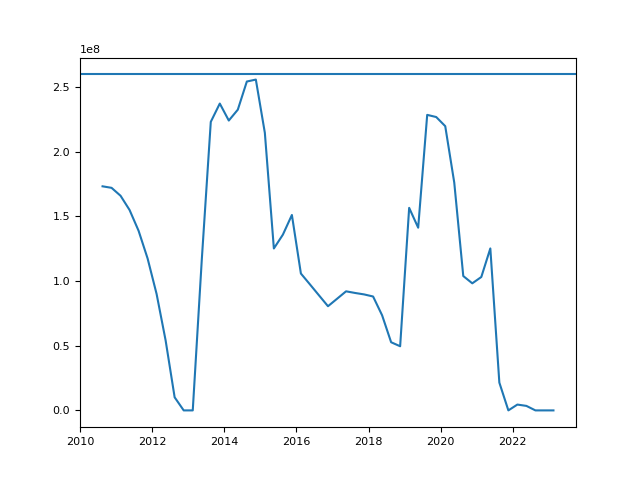

In [77]:
fig, ax = plt.subplots()
ax.axhline(lake_gdf.geometry.area.values[0])
ax.plot(df.midcyc_datetime, df['evolving_outlines_darea (m^2)'])

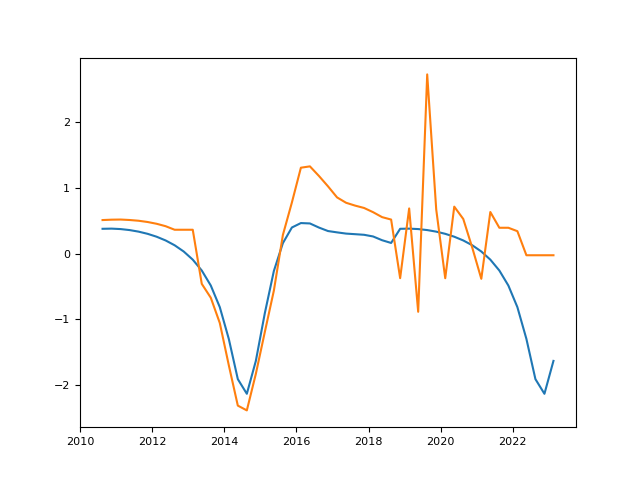

In [64]:
fig, ax = plt.subplots()
ax.plot(df.midcyc_datetime, df['static_outline_dh (m)'])
ax.plot(df.midcyc_datetime, df['evolving_outlines_dh (m)'])

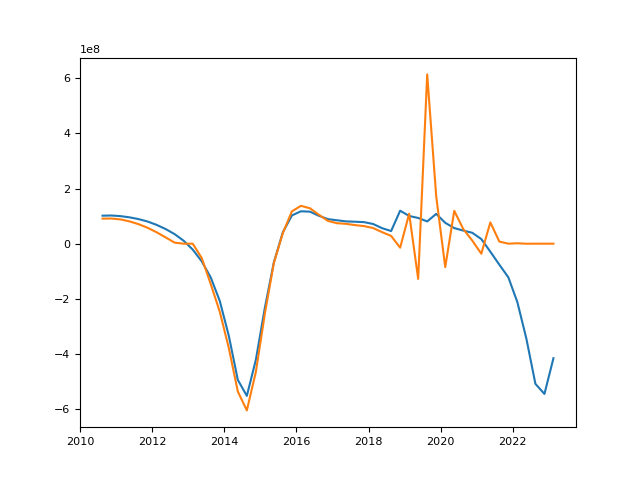

In [66]:
fig, ax = plt.subplots()
ax.plot(df.midcyc_datetime, df['static_outline_dvol_corr (m^3)'])
ax.plot(df.midcyc_datetime, df['evolving_outlines_dvol_corr (m^3)'])

# Fig. S1

In [ ]:
ROI_poly = buffered_poly
print(type(buffered_poly))
print(type(ROI_poly))

In [ ]:
ROI_poly = buffered_poly
dataset1 = CS2_dh
dataset2 = ATL15_dh

# Clipping datasets
dataset1_clipped = dataset1.rio.clip(ROI_poly, dataset1.rio.crs)
dataset2_clipped = dataset2.rio.clip(ROI_poly, dataset2.rio.crs)

# Extract min and max of x and y for dataset1
min_x1 = dataset1_clipped.x.min().item()
max_x1 = dataset1_clipped.x.max().item()
min_y1 = dataset1_clipped.y.min().item()
max_y1 = dataset1_clipped.y.max().item()

# Extract min and max of x and y for dataset2
min_x2 = dataset2_clipped.x.min().item()
max_x2 = dataset2_clipped.x.max().item()
min_y2 = dataset2_clipped.y.min().item()
max_y2 = dataset2_clipped.y.max().item()

# Check if the coordinates match
if min_x1 != min_x2 or max_x1 != max_x2 or min_y1 != min_y2 or max_y1 != max_y2:
    raise ValueError("Dataset1 and Dataset2 do not have matching x, y min, max coordinates")

# Establish x_min, x_max, y_min, y_max, 
x_min = min_x1
x_max = max_x1
y_min = min_y1
y_max = max_y1

# Subsetting datasets
# Subset datasets to region of interest for plotting
buffer = 4000
mask_x = (dataset1.x >= x_min-buffer) & (dataset1.x <= x_max+buffer)
mask_y = (dataset1.y >= y_min-buffer) & (dataset1.y <= y_max+buffer)
dataset1_subset = dataset1.where(mask_x & mask_y, drop=True)
mask_x = (dataset2.x >= x_min-buffer) & (dataset2.x <= x_max+buffer)
mask_y = (dataset2.y >= y_min-buffer) & (dataset2.y <= y_max+buffer)
dataset2_subset = dataset2.where(mask_x & mask_y, drop=True)
mask_x = (moa_highres_da.x >= x_min-buffer) & (moa_highres_da.x <= x_max+buffer)
mask_y = (moa_highres_da.y >= y_min-buffer) & (moa_highres_da.y <= y_max+buffer)
moa_highres_da_subset = moa_highres_da.where(mask_x & mask_y, drop=True)

In [ ]:
# Modify find contours function to achieve something like less than 5% of contours intersecting with buffer
# gdf = find_evolving_outlines(ROI['name'].values[0], buffered_poly, 0.5, CS2_dh, ATL15_dh)
# gdf = find_evolving_outlines(ROI['name'].values[0], buffered_poly, 0.5, CS2_dh, ATL15_dh)
gdf = find_evolving_outlines('Slessor_2_3_23', buffered_poly, 0.5, CS2_dh, ATL15_dh)

In [ ]:
# TODO
# Try other lakes

# Plot Fig. 2
fig, ax = plt.subplots(3,1, sharex=True, figsize=(5.5,16.5))


# Panel A - Plot uplift filling event
# Specify the time value you want to plot
specified_date = datetime.date(2010, 8, 17)
gdf_subset[(gdf_subset['date'] == specified_date) & (gdf_subset['dh (m)'] > 0)].boundary.plot(ax=ax[0], color='blue')
gdf_subset[(gdf_subset['date'] == specified_date) & (gdf_subset['dh (m)'] < 0)].boundary.plot(ax=ax[0], color='red')

# Calculate the absolute difference between each time in the dataset and the specified time
time_diff = np.abs(midcyc_dates - np.datetime64(specified_date))
# Find the index of the minimum difference
nearest_time_index = time_diff.argmin().item()
if nearest_time_index <= 32:
    dhdt = dataset1_subset.cyc_to_cyc_delta_h[nearest_time_index,:,:]
elif nearest_time_index > 32:
    # Subtract 33 from idx to start over with new dataset
    dhdt = dataset2_subset.cyc_to_cyc_delta_h[(nearest_time_index-33),:,:]

# Plot gridded height change data
divnorm=colors.TwoSlopeNorm(vmin=-1.5, vcenter=0., vmax=1.5)  
img = ax[0].imshow(dhdt, extent=[x_min-buffer, x_max+buffer, y_min-buffer, y_max+buffer], origin='upper', cmap='coolwarm_r', 
                   # norm=colors.CenteredNorm(),
                   norm=divnorm)

# Plot buffered polygon showing extent of evolving outline search
ROI_color = 'magenta'
gpd.GeoSeries(buffered_poly).boundary.plot(ax=ax[0], color=ROI_color)

# Create an axes on the right side of ax1 for the colorbar
cax = fig.add_axes([ax[0].get_position().x1 + 0.15, ax[0].get_position().y0 - 0.092, 0.03, ax[0].get_position().height])
fig.colorbar(img, cax=cax).set_label('height change [m]', size=12)

# Annotate time slice
ax[0].annotate('height change: {} to {}'.format(datetime64_to_fractional_year(cyc_start_dates[nearest_time_index]),
    datetime64_to_fractional_year(cyc_end_dates[nearest_time_index])), 
    xy=(-421e3,1009e3), xycoords='data', fontsize=14)


# Panel B - Plot subsidence draining event
# specified_date = datetime.date(2021, 2, 15)
specified_date = datetime.date(2020, 2, 16)
# specified_date = datetime.date(2015, 8, 17)

gdf_subset[(gdf_subset['date'] == specified_date) & (gdf_subset['dh (m)'] > 0)].boundary.plot(ax=ax[1], color='blue')
gdf_subset[(gdf_subset['date'] == specified_date) & (gdf_subset['dh (m)'] < 0)].boundary.plot(ax=ax[1], color='red')

# Calculate the absolute difference between each time in the dataset and the specified time
time_diff = np.abs(midcyc_dates - np.datetime64(specified_date))
# Find the index of the minimum difference
nearest_time_index = time_diff.argmin().item()
if nearest_time_index <= 32:
    dhdt = dataset1_subset.delta_h[nearest_time_index+1,:,:]-dataset1_subset.delta_h[nearest_time_index,:,:]
elif nearest_time_index > 32:
    # Subtract 33 from idx to start over with new dataset
    dhdt = dataset2_subset.delta_h[(nearest_time_index-33)+1,:,:]-dataset2_subset.delta_h[(nearest_time_index-33),:,:]

# Plot gridded height change data
img = ax[1].imshow(dhdt, extent=[x_min-buffer, x_max+buffer, y_min-buffer, y_max+buffer], origin='lower', cmap='coolwarm_r', 
                   # norm=colors.CenteredNorm(),
                   norm=divnorm)
gpd.GeoSeries(buffered_poly).boundary.plot(ax=ax[1], color=ROI_color)

ax[1].annotate('height change: {} to {}'.format(datetime64_to_fractional_year(cyc_start_dates[nearest_time_index]),
    datetime64_to_fractional_year(cyc_end_dates[nearest_time_index])), 
    xy=(-421e3,1009e3), xycoords='data', fontsize=14)


# Panel C - Plot outlines in aggregate vs. two past static delineations
# Plot MOA imagery  
ax[2].imshow(moa_highres_da_subset[0,:,:], cmap="gray", clim=[14000, 17000], extent=[x_min-buffer, x_max+buffer, y_min-buffer, y_max+buffer])

# Pick colormap and make continuous cmap discrete for evolving outlines
colormap = 'plasma'
continuous_cmap = matplotlib.colormaps[colormap]
discrete_cmap = colors.ListedColormap(continuous_cmap(np.linspace(0, 1, len(midcyc_dates)-1)))

# Norm to time variable
norm = plt.Normalize(mdates.date2num(midcyc_dates[0]), 
                     mdates.date2num(midcyc_dates[-1]))

# Use for loop to store each time slice as line segment to use in legend
# And plot each outline in the geopandas dataframe and color by date
lines = []  # list of lines to be used for the legend
for idx, dt in enumerate(midcyc_dates, 0):
    x = 1; y = 1
    line, = ax[2].plot(x, y, color=discrete_cmap(norm(mdates.date2num(midcyc_dates[idx]))), linewidth=3)
    lines.append(line)
    
    # Filter rows that match the current time slice
    gdf_subset_dt = gdf_subset[gdf_subset['datetime'] == dt]

    # Plotting the subset
    gdf_subset_dt.plot(ax=ax[2], edgecolor=discrete_cmap(norm(mdates.date2num(midcyc_dates[idx]))), facecolor='none')

    
# All panels
# Label axes
ax[2].set_xlabel('x [km]', size=16)
ax[1].set_ylabel('y [km]', size=16)

# ax[0].annotate('A', xy=(-425e3,1049e3), xycoords='data', fontsize=30)
# ax[1].annotate('B', xy=(-425e3,1049e3), xycoords='data', fontsize=30)
# ax[2].annotate('C', xy=(-425e3,1049e3), xycoords='data', fontsize=30)
ax[0].annotate('A', xy=(0.02, 0.9), xycoords='axes fraction', fontsize=30)
ax[1].annotate('B', xy=(0.02, 0.9), xycoords='axes fraction', fontsize=30)
ax[2].annotate('C', xy=(0.02, 0.9), xycoords='axes fraction', fontsize=30)

# Create lines for legend
S09_color = 'lightseagreen'
SF18_color = 'teal'
Smith2009 = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 2)), linewidth=3)
SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=(0, (1, 1)), linewidth=3)
ROI = plt.Line2D((0, 1), (0, 0), color=ROI_color, linestyle='solid', linewidth=3)
uplift = plt.Line2D((0, 1), (0, 0), color='blue', linewidth=3)
subsidence = plt.Line2D((0, 1), (0, 0), color='red', linewidth=3)

# Create legends
ax[0].legend([Smith2009, SiegfriedFricker2018, ROI, uplift], 
           ['static outline [10]',
            'static outline [13]', 
            # 'evolving outline ({} m threshold)'.format(threshold)], 
            'evolving outline search limit [this study]',
            'evolving outline - uplift [this study]'], 
             loc='upper right') 

ax[1].legend([subsidence],
           ['evolving outline - subsidence [this study]'], 
             loc='upper right')

legend = ax[2].legend([tuple(lines)], ['evolving outlines [this study]'],
    handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    loc='upper center')
legend.get_frame().set_linewidth(0.0)
ax[2].patch.set_alpha(1)

# Create colorbar 
m = plt.cm.ScalarMappable(cmap=discrete_cmap)
m.set_array(np.array([datetime64_to_fractional_year(date) for date in midcyc_dates[0:]]))
cax = inset_axes(ax[2],
                 width="100%",
                 height="2.5%",
                 loc=3,
                 bbox_to_anchor=[0,-0.14,1,1],
                 bbox_transform=ax[2].transAxes,
                 borderpad=0,
                 )
cbar=fig.colorbar(m, ticks=np.array([2010,2012,2014,2016,2018,2020,2022]), 
             cax=cax, orientation='horizontal').set_label('evolving outline year', size=15)

# Plot inset map
axIns = ax[0].inset_axes([0.01, 0.01, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
axIns.set_aspect('equal')
moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
axIns.axis('off')
# # Plot black rectangle to indicate location
# rect = Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), fill=False, linewidth=2, color='k', zorder=3)
# axIns.add_artist(rect)
# Plot red star to indicate location
axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
    linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)

# # Add annotation to the opposite side of the colorbar
# cbar.ax.text(1.1, 0.5, 'CryoSat-2 era', va='center', ha='left', transform=cbar.ax.transAxes)

for i in ax: 
    S09_outlines.boundary.plot(ax=i, edgecolor=S09_color, facecolor='none', linestyle=(0, (1, 2)), linewidth=3, alpha=1, zorder=0)
    SF18_outlines_SF18only.boundary.plot(ax=i, edgecolor=SF18_color, facecolor='none', linestyle=(0, (1, 1)), linewidth=3, alpha=1, zorder=0)
    
    # Change polar stereographic m to km
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    i.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    i.yaxis.set_major_formatter(ticks_y)
    
    # i.set(xlim=(x_min-buffer, x_max+buffer), ylim=(y_min-buffer, y_max+buffer))   
    i.set(xlim=(x_min-buffer, x_max+buffer), ylim=(y_min-buffer, y_max+buffer))   

plt.tight_layout()

plt.show()

Folder '/home/jovyan/1_outlines_candidates/output/FigS1_lake_reexamination_methods.ipynb/plot_data_counts' already exists.
Folder '/home/jovyan/1_outlines_candidates/output/FigS1_lake_reexamination_methods.ipynb/plot_data_counts/LowerSubglacialLakeConway' already exists.
Now creating/saving plots...


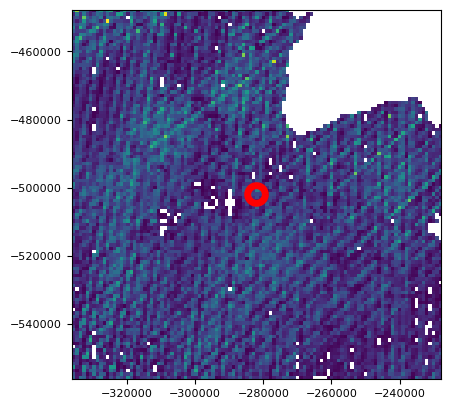

In [110]:
# I can't figure out why data_counts plot looks sparse when you plot at continental scale
plt.close()
for idx in range(145, len(lake_locations)):

    # Define lake name and polygon
    lake_name = lake_gdf.name.values[0]
    lake_poly = lake_gdf.iloc[0].geometry

    # # Create buffered polygons for various multiples of lake area to find which
    # # best emcompasses the height change signals at previously identified lakes
    buffered_poly_2x = muliple_area_buffer(lake_poly, 2)
    # buffered_poly_3x = muliple_area_buffer(lake_poly, 3)
    # buffered_poly_4x = muliple_area_buffer(lake_poly, 4)
    # buffered_poly_5x = muliple_area_buffer(lake_poly, 5)

    # Establish x_min, x_max, y_min, y_max
    x_min, y_min, x_max, y_max = buffered_poly_2x.iloc[0].geometry.bounds
    x_buffer = abs(x_max-x_min)*10
    y_buffer = abs(y_max-y_min)*10

    # Subsetting datasets
    mask_x = (dataset1.x >= x_min - x_buffer) & (dataset1.x <= x_max + x_buffer)
    mask_y = (dataset1.y >= y_min - y_buffer) & (dataset1.y <= y_max + y_buffer)
    dataset1_subset = dataset1.where(mask_x & mask_y, drop=True)
    mask_x = (dataset2.x >= x_min - x_buffer) & (dataset2.x <= x_max + x_buffer)
    mask_y = (dataset2.y >= y_min - y_buffer) & (dataset2.y <= y_max + y_buffer)
    dataset2_subset = dataset2.where(mask_x & mask_y, drop=True)

    # Make output folders
    create_folder(OUTPUT_DIR + '/{}'.format('plot_data_counts'))
    create_folder(OUTPUT_DIR + '/plot_data_counts/{}'.format(lake_name))
    print('Now creating/saving plots...')

    # Create lines for legend
    S09_color = 'cyan'
    SF18_color  = 'darkcyan'
    lakes_notSF18_color = 'deepskyblue'
    Smith2009 = plt.Line2D((0, 1), (0, 0), color=S09_color, linestyle=(0, (1, 3)), linewidth=2)
    SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color=SF18_color, linestyle=(0, (1, 2)), linewidth=2)
    lakes_notSF18 = plt.Line2D((0, 1), (0, 0), color=lakes_notSF18_color, linestyle=(0, (1, 1)), linewidth=2)

    # Calculate cycle-to-cycle dHeight at each cycle of the spliced data sets
    for idx in range(33,34):#len(midcyc_dates)):
        # For midcyc_dates indexes <= 32, use CryoSat-2 dataset for cycle-to-cycle dHeight
        # This covers the CryoSat-2 era before ICESat-2 launch (2010-08-17 to 2018-08-17)
        if idx <= 32:
            count_subset = dataset1_subset['data_count'][idx,:,:]
            count_subset.rio.write_crs("epsg:3031", inplace=True)

        # For midcyc_dates indexes > 32, use ICESat-2 dataset for cycle-to-cycle dHeight
        # This covers the ICESat-2 era (2018-11-16 to most recently available data)
        elif idx > 32:
            # Subtract 33 from idx to start over at index zero with new dataset
            count_subset = dataset2_subset['data_count'][(idx-33),:,:]
            count_subset.rio.write_crs("epsg:3031", inplace=True)

        # Only plot arrays that have data in them; some time slices have no data because no CryoSat-2 SARIn coverage
        # Returns True if there is at least one non-NaN value in data_stacked, and False if all values are NaN
        # if np.any(~np.isnan(count_subset)):
        # Create fig, ax
        fig, ax = plt.subplots()

        # Plot figure
        img = ax.imshow(count_subset, extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer], 
            origin='lower', cmap='viridis')

        buffered_poly_2x.boundary.plot(ax=ax, edgecolor='r', facecolor='none', linewidth=5)

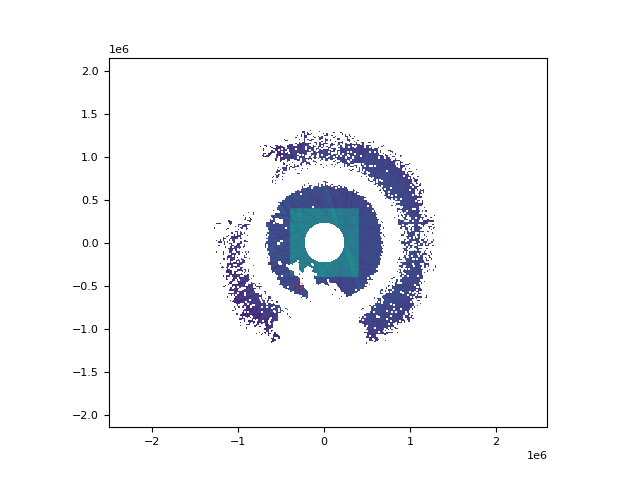

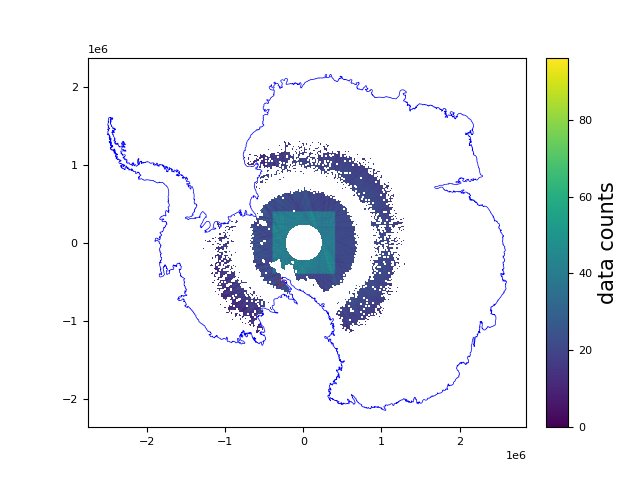

In [116]:
# Only plot arrays that have data in them; some time slices have no data because no CryoSat-2 SARIn coverage
# Returns True if there is at least one non-NaN value in data_stacked, and False if all values are NaN
# if np.any(~np.isnan(count_subset)):
plt.close()
# Create fig, ax
fig, ax = plt.subplots()

idx=44

# Plot figure
img = ax.imshow(dataset2['data_count'][(idx-33),:,:], 
    # extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer],
    extent=[dataset2.x.min(), dataset2.x.max(), dataset2.y.min(), dataset2.y.max()], 
    origin='lower', 
    # cmap='viridis'
    )

buffered_poly_2x.boundary.plot(ax=ax, edgecolor='r', facecolor='none', linewidth=5)
plt.show()
Scripps_landice.boundary.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=0.5)

# Add colorbar 
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(img, cax=cax).set_label('data counts', size=15)

plt.show()